In [79]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline 
import seaborn as sns
import pandas as pd
sns.set_style("whitegrid")
sns.set_context("poster")
from sklearn import linear_model,svm,ensemble,tree

# special matplotlib argument for improved plots
from matplotlib import rcParams

import samples
reload(samples)
import spectral
reload(spectral)
import audiolearning
reload(audiolearning)
import mytimer as mt
reload(mt)
print

In [3]:
FFT_BINS = 60;
FWIN = 25;
TWIN = 1;
NPERSEG = 1024;
TSUB = 1; #NOTE: this will be used only for training. Will experiment with test format later.
NSUB = 10;
#Last day of 'training' data
MONTH = 5;
DAY = 29;

In [4]:
data_file = 'sped_mfccPhi_%02i%02i_%i_%i_%i_%i_%i_%i.pkl'%(MONTH,DAY,TSUB,NSUB,FFT_BINS,FWIN,TWIN,NPERSEG)
LOAD_DATA = True;

In [5]:
class phi_sped_mfcc:
    LEN = 0;
    def __init__(self,fft_bins):
        #self.LEN = fft_bins;
        self.LEN = fft_bins+13;
        self.fft_bins = fft_bins;

    def get_phi(self,sample):
        '''
        Takes in a super_sample and returns a feature array. Breaks the super_sample
        down into samples. Each row of the returned value corresponds to a sample
        in the super sample.
        '''

        XSPED = spectral.getSupersampleSPED(sample,self.fft_bins,fwin=FWIN,twin = TWIN,nperseg = NPERSEG,spacing="log")
        XMFCC = spectral.getSampleMFCC(sample)
        return np.hstack((XMFCC,XSPED))

In [6]:
myPhi = phi_sped_mfcc(FFT_BINS)
extractor = audiolearning.Classifier(myPhi)

In [21]:
if os.path.exists(data_file):
    with open(data_file,"rb") as myPkl:
        thisData = pickle.load(myPkl);
        X = thisData.X;
        Y = thisData.Y;
        X_compact = thisData.X_samples
        Y_compact = thisData.Y_samples
    m, nsub, nfeat = np.shape(X_compact)
else:
    all_samples = samples.getAllSamples(Tsub=TSUB,Nsub=NSUB,READ_IN=False)
    (X_compact,Y_compact) = extractor.extract_features(all_samples)
    m, nsub, nfeat = np.shape(X_compact)
    X = np.reshape(X_compact,(m*nsub,nfeat))
    Y = np.repeat(Y_compact,nsub)
    thisData = samples.DataPhi()
    thisData.X = X
    thisData.Y = Y
    thisData.X_samples = X_compact
    thisData.Y_samples = Y_compact
    with open(data_file,'wb') as f:
        pickle.dump(thisData,f)

(array([ 1140.,  1200.,  1200.,  1320.,  1200.,  1020.,   900.]),
 array([0, 1, 2, 3, 4, 5, 6, 7]),
 <a list of 7 Patch objects>)

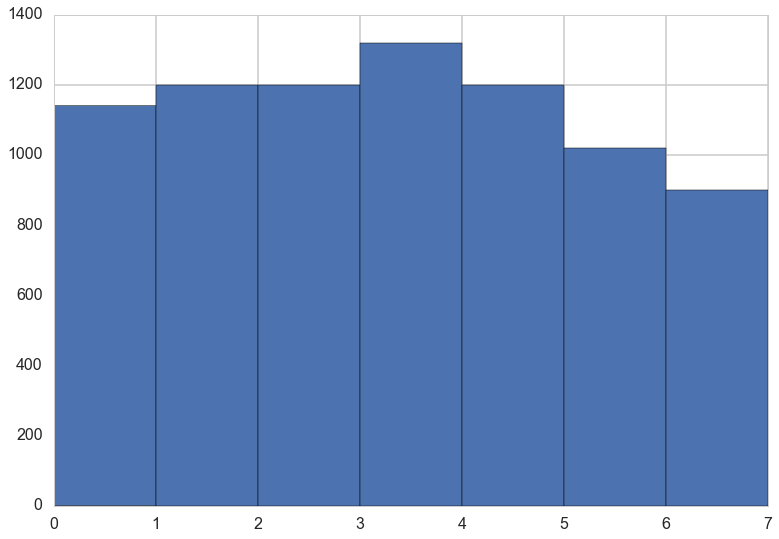

In [43]:
plt.hist(Y,range(8))

In [9]:
mfcc_names =  ['MFCC' + str(i) for i in range(13)]
sped_names = ['SPED_Bin' + str(i) for i in range(FFT_BINS)]
col_names = mfcc_names + sped_names
X_df = pd.DataFrame(X)
X_df.columns = col_names
X_df['REGION'] = Y
X_df.head()

MFCC0     MFCC1     MFCC2     MFCC3     MFCC4     MFCC5     MFCC6  \
0 -25.918079 -0.008070  0.172488 -0.140354  0.329311 -0.029216  0.140779   
1 -25.966328 -0.258913  0.292604 -0.070700  0.162208 -0.072497  0.106541   
2 -25.957831 -0.204486  0.295049 -0.052674  0.266495 -0.084051  0.187803   
3 -25.973699 -0.073244  0.306785 -0.087720  0.280578 -0.085753  0.211136   
4 -26.030975 -0.106581  0.374309 -0.119022  0.298362 -0.053834  0.153209   

      MFCC7     MFCC8     MFCC9   ...    SPED_Bin51  SPED_Bin52  SPED_Bin53  \
0  0.003680  0.086454 -0.048726   ...            12          16          12   
1 -0.074517 -0.013643 -0.024632   ...            15          13          15   
2 -0.044129  0.026562 -0.042559   ...            14          11          14   
3 -0.120926 -0.012469 -0.061531   ...            13          13          16   
4 -0.174730  0.100719 -0.128079   ...            14          19          15   

   SPED_Bin54  SPED_Bin55  SPED_Bin56  SPED_Bin57  SPED_Bin58  SPED_Bin59  \
0          19          14          18          18          19          11   
1          18          15          21          18          17          13   
2          15          19          19          16          21           8   
3          12          18          19          16          15          16   
4          12          20          21          15          27          14   

   REGION  
0       6  
1       6  
2       6  
3       6  
4       6  

[5 rows x 74 columns]

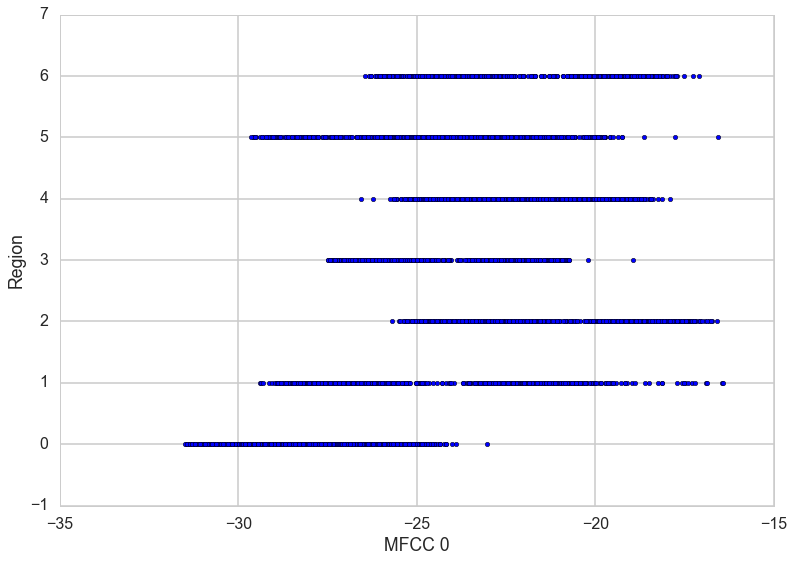

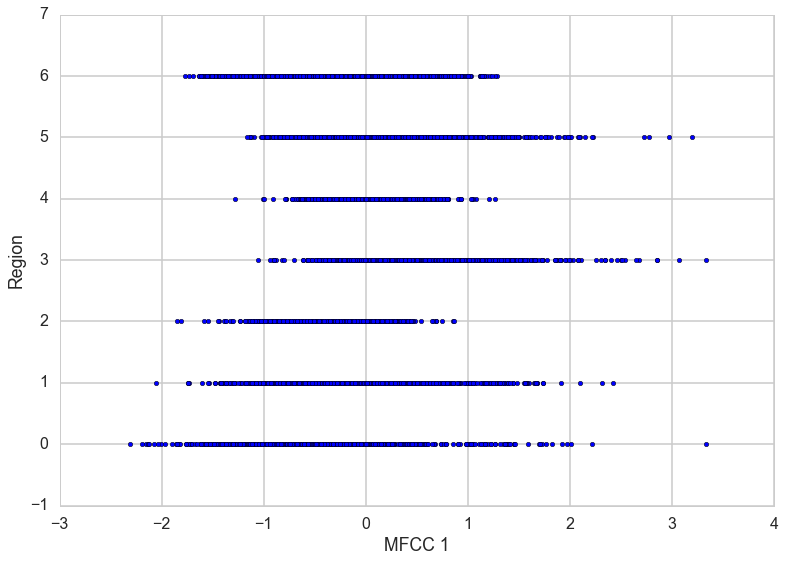

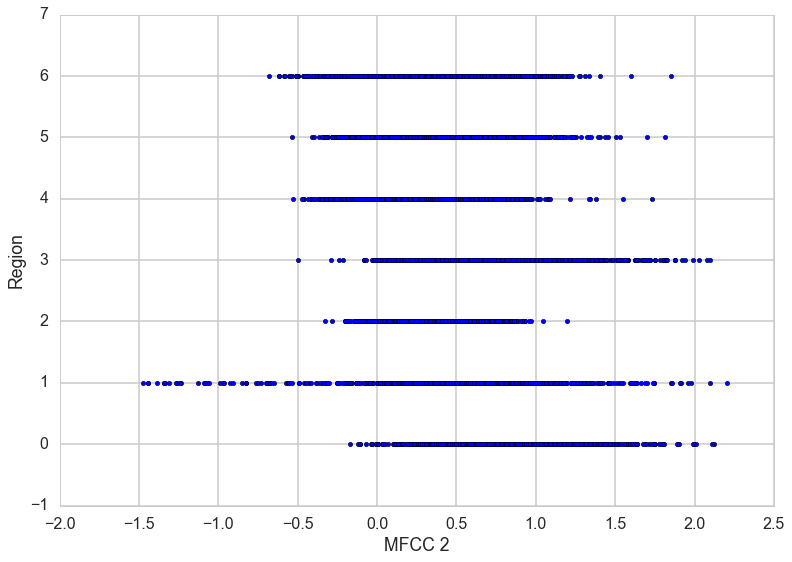

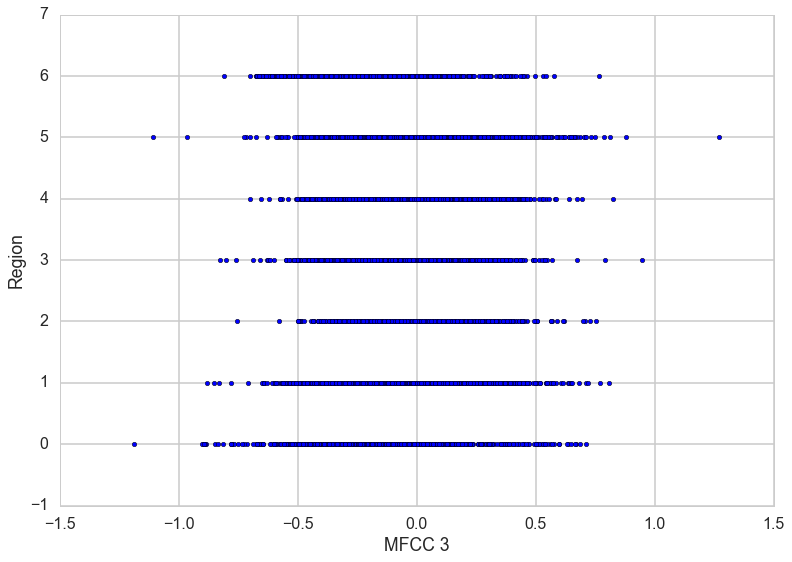

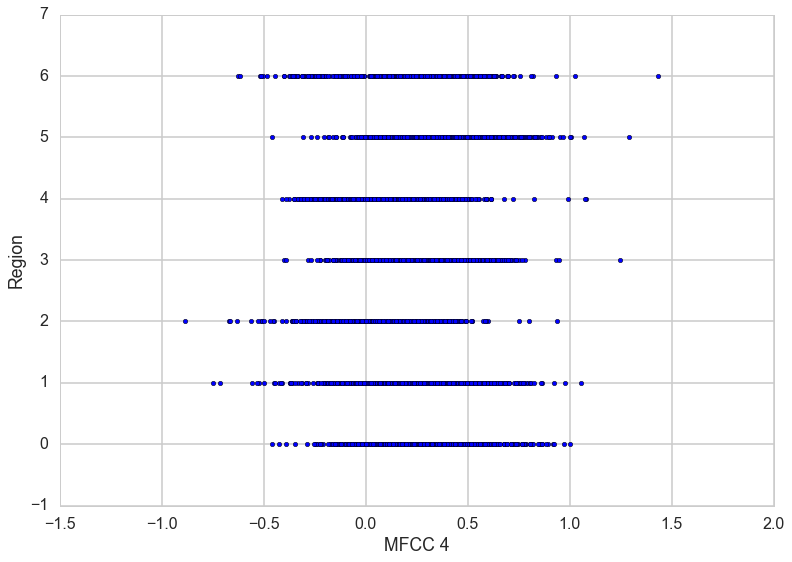

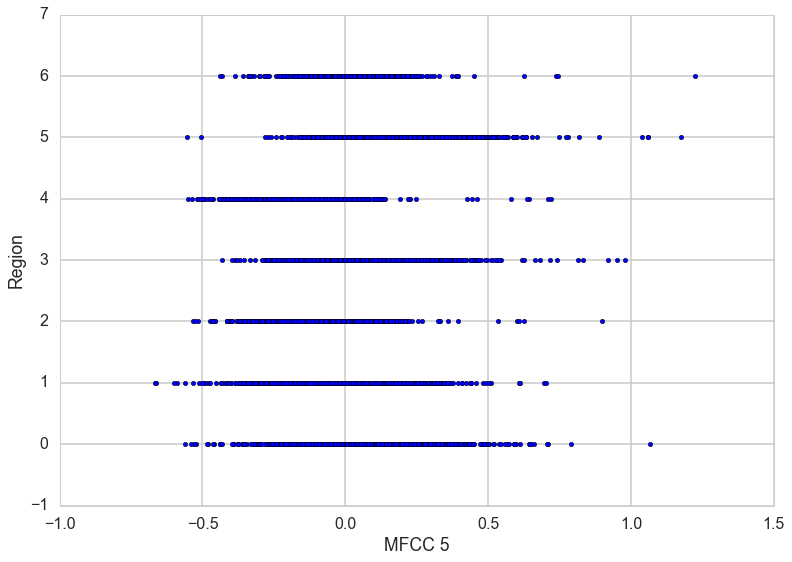

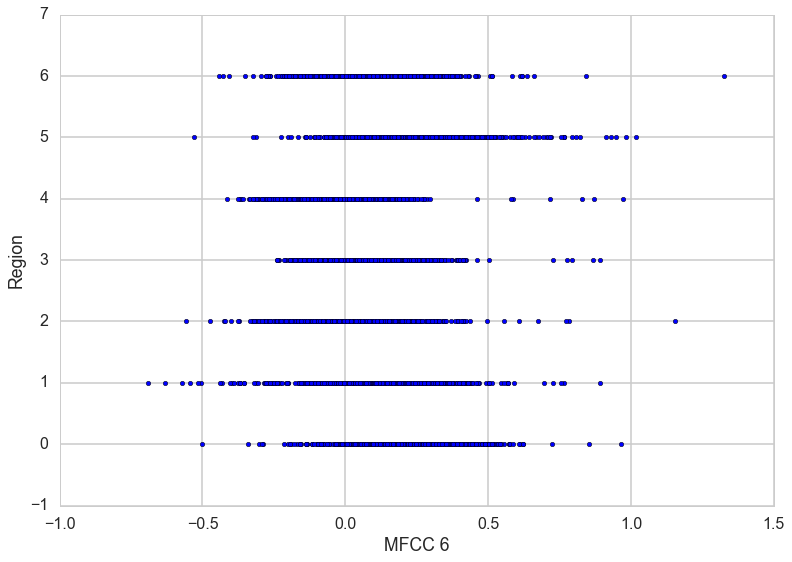

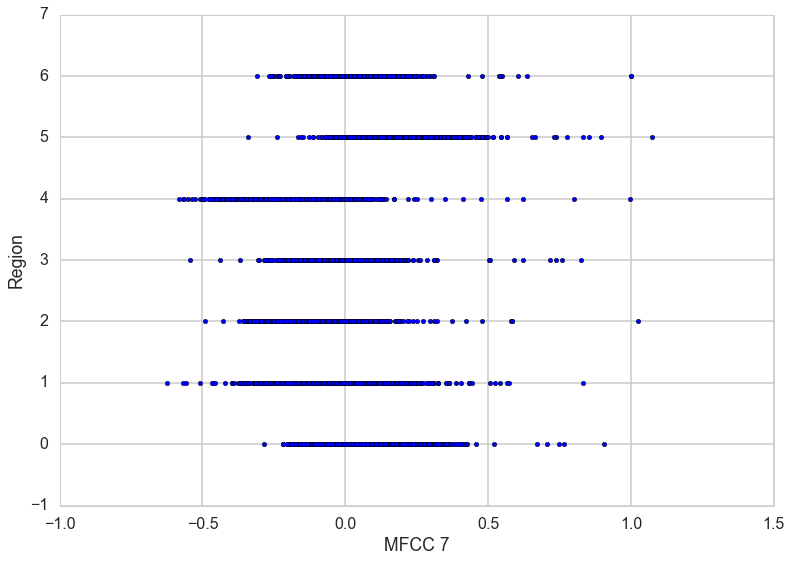

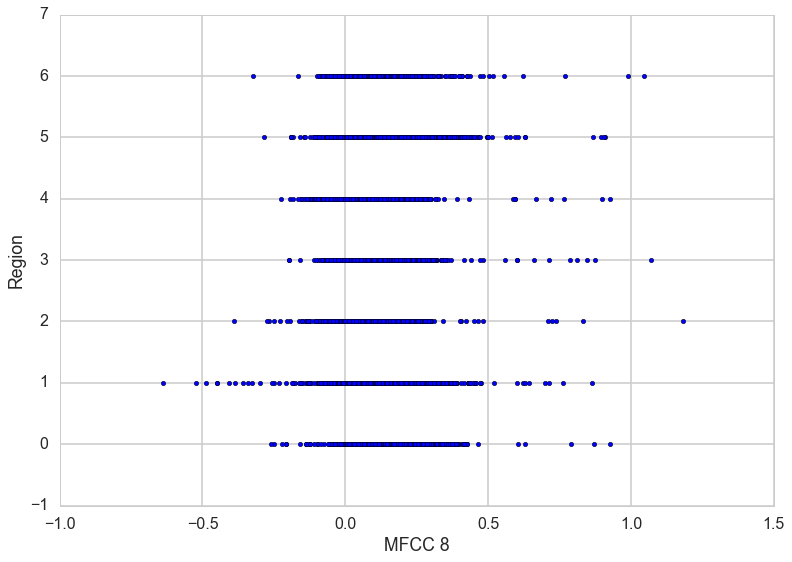

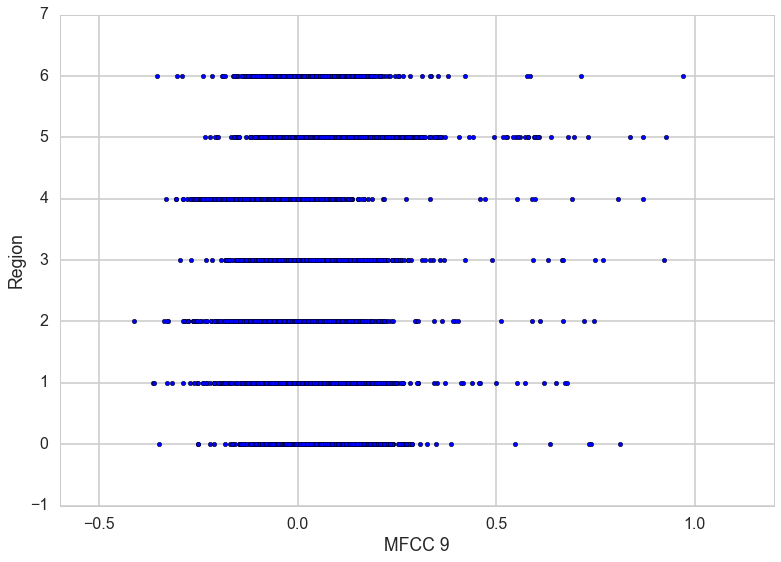

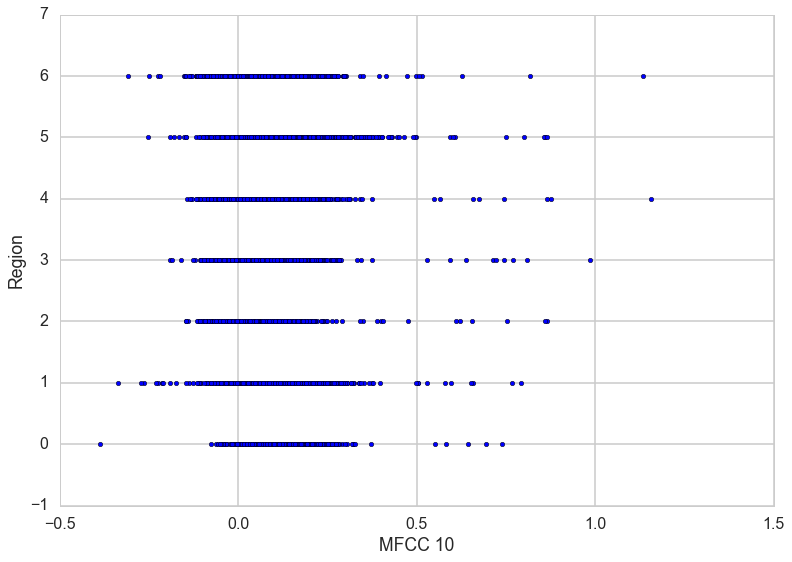

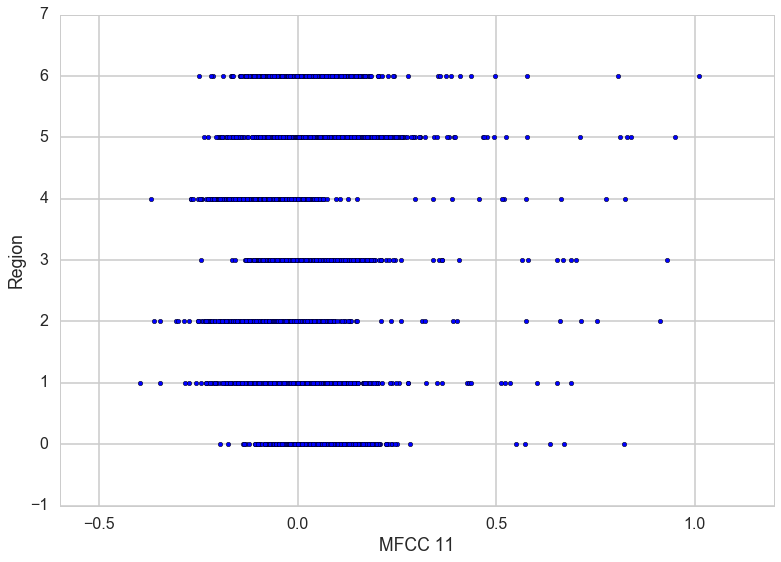

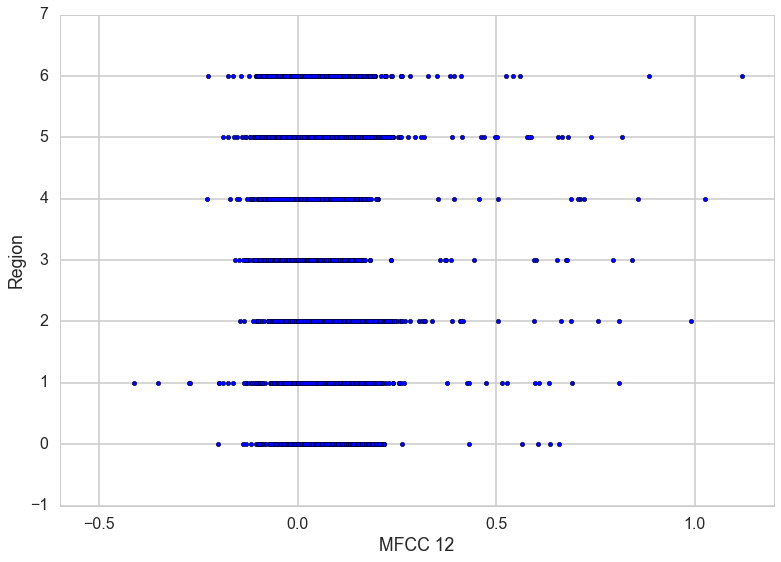

In [10]:
for i in range(13):
    plt.scatter(X_df['MFCC'+str(i)],X_df['REGION'])
    plt.xlabel("MFCC " + str(i))
    plt.ylabel("Region")
    plt.show()

In [11]:
classes = X_df.groupby('REGION')

In [12]:
classes.describe()

MFCC0        MFCC1       MFCC10       MFCC11       MFCC12  \
REGION                                                                          
0      count  1140.000000  1140.000000  1140.000000  1140.000000  1140.000000   
       mean    -28.162102    -0.440557     0.126891     0.054764     0.075373   
       std       1.901193     0.634646     0.074582     0.075717     0.064865   
       min     -31.481809    -2.307413    -0.387417    -0.195779    -0.199860   
       25%     -29.766843    -0.804520     0.080265     0.007055     0.040992   
       50%     -28.582142    -0.517107     0.122713     0.049892     0.076003   
       75%     -26.337624    -0.124916     0.167890     0.096625     0.106948   
       max     -23.031964     3.338607     0.740045     0.822839     0.659298   
1      count  1200.000000  1200.000000  1200.000000  1200.000000  1200.000000   
       mean    -24.306633    -0.034028     0.112308     0.007860     0.058835   
       std       2.945531     0.634621     0.096046     0.090087     0.081255   
       min     -29.393079    -2.056050    -0.337738    -0.396665    -0.413135   
       25%     -27.242337    -0.473900     0.058749    -0.038672     0.015748   
       50%     -23.158224    -0.025337     0.112050     0.005743     0.055881   
       75%     -21.786341     0.383154     0.163878     0.050549     0.096521   
       max     -16.427706     2.418469     0.792990     0.687720     0.810613   
2      count  1200.000000  1200.000000  1200.000000  1200.000000  1200.000000   
       mean    -20.840585    -0.303287     0.055871    -0.035580     0.059712   
       std       2.307928     0.360526     0.083535     0.087400     0.082494   
       min     -25.687415    -1.851440    -0.146003    -0.361527    -0.144843   
       25%     -22.903377    -0.531828     0.010837    -0.079064     0.015980   
       50%     -20.128841    -0.303021     0.048805    -0.032431     0.047673   
       75%     -18.790856    -0.047682     0.091365     0.004502     0.090499   
       max     -16.594068     0.868365     0.864909     0.914093     0.991336   
3      count  1320.000000  1320.000000  1320.000000  1320.000000  1320.000000   
       mean    -24.122033     0.615771     0.082741     0.022757     0.031986   
       std       2.001433     0.538918     0.089539     0.082429     0.075451   
       min     -27.480627    -1.057673    -0.191070    -0.244690    -0.159195   
       25%     -26.302620     0.285791     0.035400    -0.023969    -0.007443   
       50%     -23.129742     0.648295     0.072935     0.009932     0.030778   
       75%     -22.484287     0.928339     0.121462     0.057695     0.064265   
       max     -18.955462     3.332494     0.986220     0.929688     0.841964   
4      count  1200.000000  1200.000000  1200.000000  1200.000000  1200.000000   
       mean    -21.495779     0.125892     0.071105    -0.070416     0.030291   
       std       1.867725     0.317909     0.093704     0.085037     0.080448   
       min     -26.558420    -1.281678    -0.142084    -0.369688    -0.228190   
       25%     -23.117824    -0.052540     0.020574    -0.119421    -0.009596   
       50%     -20.955538     0.154046     0.062900    -0.070779     0.026333   
       75%     -19.888839     0.331610     0.107795    -0.030819     0.060392   
       max     -17.914661     1.263707     1.156533     0.824655     1.027061   
5      count  1020.000000  1020.000000  1020.000000  1020.000000  1020.000000   
       mean    -24.363330     0.221584     0.141188     0.078342     0.076494   
       std       2.128144     0.620593     0.116658     0.111542     0.092439   
       min     -29.643374    -1.165313    -0.251472    -0.237191    -0.187783   
       25%     -25.530191    -0.203307     0.071952     0.020571     0.031477   
       50%     -24.508011     0.129492     0.137237     0.079226     0.072243   
       75%     -23.087980     0.550978     0.197823     0.128639     0.113431   
       max     -16.567036     3.198728     0.865331

In [13]:
classes.get_group(0).head()

MFCC0     MFCC1    MFCC10    MFCC11    MFCC12     MFCC2     MFCC3  \
5640 -26.873158 -0.653411  0.208576 -0.008484  0.055788  0.373997 -0.435972   
5641 -26.921664 -0.628503  0.188995  0.029489  0.120771  0.454278 -0.296170   
5642 -26.634897 -0.567841  0.248900  0.087849  0.109637  0.605595 -0.318652   
5643 -26.580003 -0.554923  0.168907  0.076883  0.145709  0.702235 -0.219895   
5644 -26.611434 -0.609800  0.250711  0.037579  0.171509  0.610626 -0.256571   

         MFCC4     MFCC5     MFCC6    ...      SPED_Bin54  SPED_Bin55  \
5640  0.135274 -0.171036 -0.001735    ...              12          15   
5641  0.311315 -0.094074  0.078612    ...              16          15   
5642  0.329879  0.035038  0.085161    ...              12          13   
5643  0.380643 -0.041731  0.020338    ...              12          19   
5644  0.264436 -0.020244 -0.005966    ...              14          17   

      SPED_Bin56  SPED_Bin57  SPED_Bin58  SPED_Bin59  SPED_Bin6  SPED_Bin7  \
5640          13          20          17          12          0          0   
5641          17          17          17          12          0          0   
5642          15          14          21          13          0          0   
5643          15          16          18          13          0          0   
5644          14          20          20          11          0          0   

      SPED_Bin8  SPED_Bin9  
5640          1          2  
5641          0          0  
5642          0          0  
5643          0          0  
5644          0          0  

[5 rows x 73 columns]

In [14]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

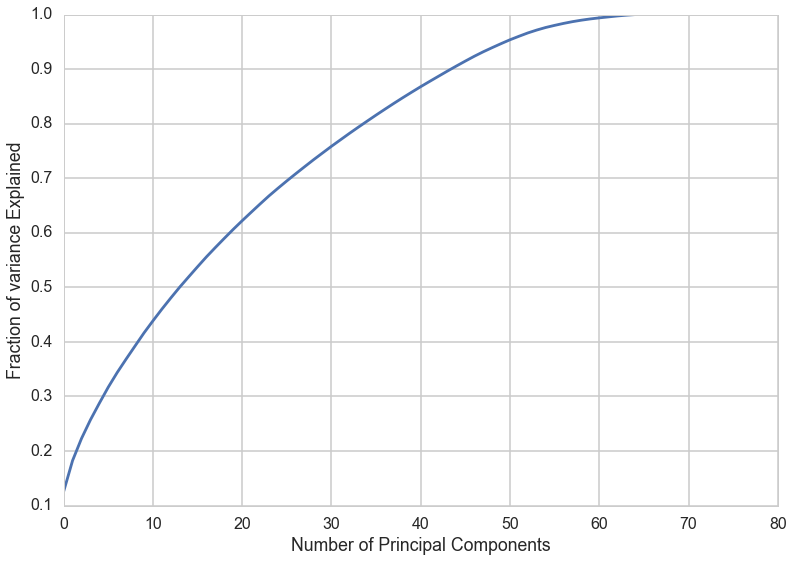

In [15]:
pca = PCA(n_components=None)

X_pca = pca.fit_transform(preprocessing.scale(X),Y)
var_thresh = 0.95
var_exp = pca.explained_variance_ratio_.cumsum()
plt.plot(var_exp)
num_pcs = np.where(var_exp>=var_thresh)[0][0]
plt.xlabel('Number of Principal Components')
plt.ylabel('Fraction of variance Explained')
print

In [16]:
#num_pcs = len(var_exp)
print "Number of Principal Components to explain %.2f%% of variance: %d" %(var_thresh*100,num_pcs)
pca.set_params(n_components=num_pcs)

Number of Principal Components to explain 95.00% of variance: 50


PCA(copy=True, n_components=50, whiten=False)

In [17]:
pca_df = pd.DataFrame()

for i in range(num_pcs):
    pca_df["pc%i" % (i+1)] = X_pca[:,i]
    
pca_df['REGION'] = Y
pca_classes = pca_df.groupby('REGION')
pca_classes.describe()

pc1         pc10         pc11         pc12         pc13  \
REGION                                                                          
0      count  1140.000000  1140.000000  1140.000000  1140.000000  1140.000000   
       mean     -1.880687    -0.029316    -0.039832     0.233213     0.114453   
       std       1.641316     1.003363     0.768267     0.790113     0.894940   
       min     -12.403009    -4.689727    -4.766858    -3.221911    -5.375626   
       25%      -2.811828    -0.608126    -0.464992    -0.244267    -0.297462   
       50%      -1.777153    -0.046308    -0.014883     0.223596     0.234517   
       75%      -1.066459     0.495402     0.426412     0.713041     0.668062   
       max       4.874173     4.542964     2.754959     4.706714     3.444104   
1      count  1200.000000  1200.000000  1200.000000  1200.000000  1200.000000   
       mean     -0.546440     0.326770    -0.021349    -0.092635     0.175084   
       std       2.072140     1.188546     1.208978     1.461157     1.141276   
       min     -12.027520    -6.868643    -7.689075    -5.517712    -5.478819   
       25%      -1.785796    -0.333196    -0.676986    -0.736837    -0.412210   
       50%      -0.840758     0.345337     0.015313    -0.171761     0.179141   
       75%       0.269114     1.071613     0.713673     0.424481     0.824635   
       max       9.158668     4.701393     4.848751    16.418611     5.734245   
2      count  1200.000000  1200.000000  1200.000000  1200.000000  1200.000000   
       mean      2.054325    -0.170557    -0.186469     0.061842     0.005254   
       std       1.770615     1.292129     1.165306     1.130421     1.137953   
       min     -10.811165    -5.638503    -5.496902    -2.871893    -4.523419   
       25%       1.056784    -0.980661    -0.887536    -0.637517    -0.734692   
       50%       1.982701    -0.156971    -0.165035    -0.016743     0.014633   
       75%       3.063008     0.676195     0.568442     0.718261     0.724472   
       max       7.831894     4.815522     4.013142     7.728578     3.965988   
3      count  1320.000000  1320.000000  1320.000000  1320.000000  1320.000000   
       mean     -0.896423    -0.035732     0.001775    -0.353287    -0.010695   
       std       1.387333     0.896266     0.919796     0.815855     0.797493   
       min     -13.879028    -4.133544   -10.956864    -7.107992    -4.316825   
       25%      -1.643722    -0.549916    -0.399362    -0.798683    -0.449726   
       50%      -0.804748    -0.020376     0.078947    -0.337843     0.008019   
       75%      -0.087187     0.477134     0.539944     0.136163     0.487789   
       max       6.453156     4.023877     2.283533     2.653340     4.074609   
4      count  1200.000000  1200.000000  1200.000000  1200.000000  1200.000000   
       mean      4.020097    -0.224982     0.034678    -0.143368    -0.229205   
       std       2.519119     1.649273     1.488880     1.011774     1.589068   
       min     -11.524718    -8.069889    -5.741808    -3.179586    -5.167403   
       25%       2.324621    -1.167131    -0.823626    -0.799880    -1.239722   
       50%       3.846049    -0.154492     0.062636    -0.133676    -0.222540   
       75%       5.739585     0.890546     0.981882     0.502355     0.755532   
       max      10.107597     4.536112     5.763376     3.637000     5.067674   
5      count  1020.000000  1020.000000  1020.000000  1020.000000  1020.000000   
       mean     -2.706057    -0.028181    -0.188380     0.177047     0.245562   
       std       1.778736     1.105176     1.310926     1.169846     0.963350   
       min     -14.547943    -4.683622    -5.363077    -5.495297    -3.138050   
       25%      -3.686659    -0.707868    -0.828368    -0.404649    -0.288749   
       50%      -2.737450    -0.017439    -0.007328     0.262306     0.251244   
       75%      -1.852364     0.645342     0.609684     0.849941     0.843261   
       max       4.437996     3.862365     4.540779  

In [18]:
samples.REGIONS

['Rains', 'Circle', 'Tresidder', 'Huang', 'Bytes', 'Oval', 'Arrillaga']

In [19]:
def plotRegions(regions,dataframe,i=None,j=None):
    num = len(regions)
    colors = sns.color_palette("hls", 8)
    markers = ['^','o','x','v','<','>','*']
    fig =plt.figure()
    ax = Axes3D(fig,elev=-140, azim=80)
    if i==None:
        for region_name,color,marker in zip(regions,colors,markers):
            region = samples.Regions_dict[region_name]
            mask = pca_df['REGION']==region
            ax.scatter(pca_df[mask]['pc1'],pca_df[mask]['pc2'],pca_df[mask]['pc3'],c=color,label=region_name,marker=marker)
    else:
        region_name = samples.REGIONS[i]
        mask = pca_df['REGION']==i
        ax.scatter(pca_df[mask]['pc1'],pca_df[mask]['pc2'],pca_df[mask]['pc3'],c=colors[i],label=region_name,marker=markers[i])
        region_name = samples.REGIONS[j]
        mask = pca_df['REGION']==j
        ax.scatter(pca_df[mask]['pc1'],pca_df[mask]['pc2'],pca_df[mask]['pc3'],c=colors[j],label=region_name,marker=markers[j])


    plt.legend()
    plt.title('First 3 Principal Components')
    plt.show()

# Plotting All The Regions Together Based on the First 3 PCs is pretty messy

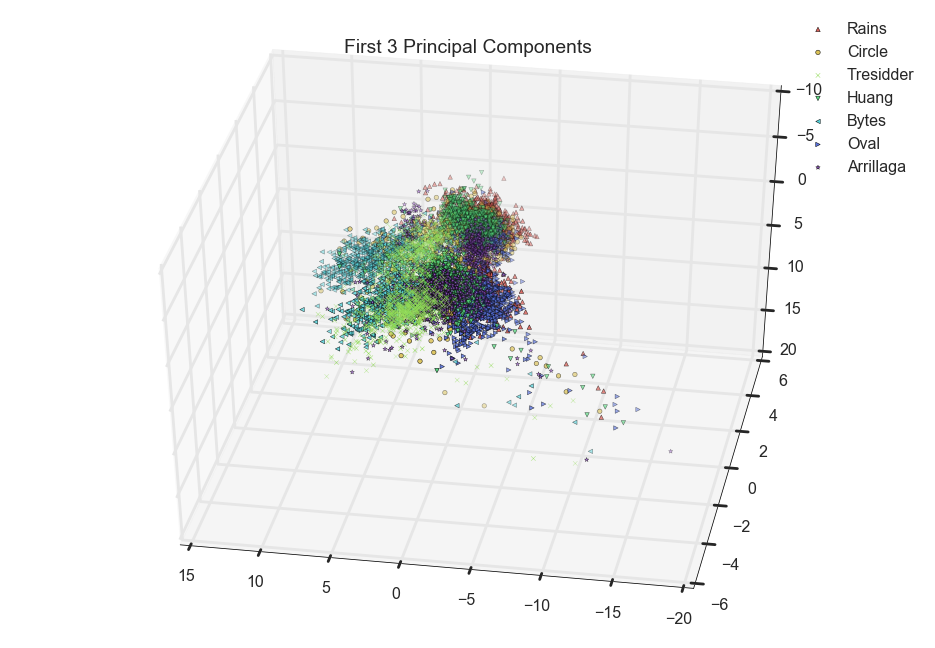

In [38]:
plotRegions(samples.REGIONS,pca_df)

# But Plotting Them Pairwise is Pretty Interesting

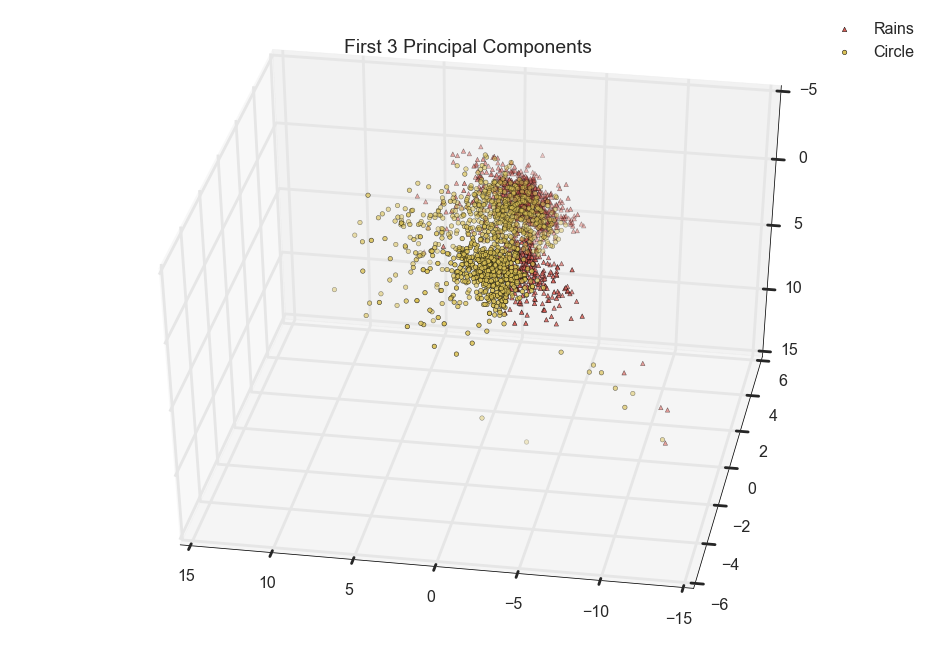

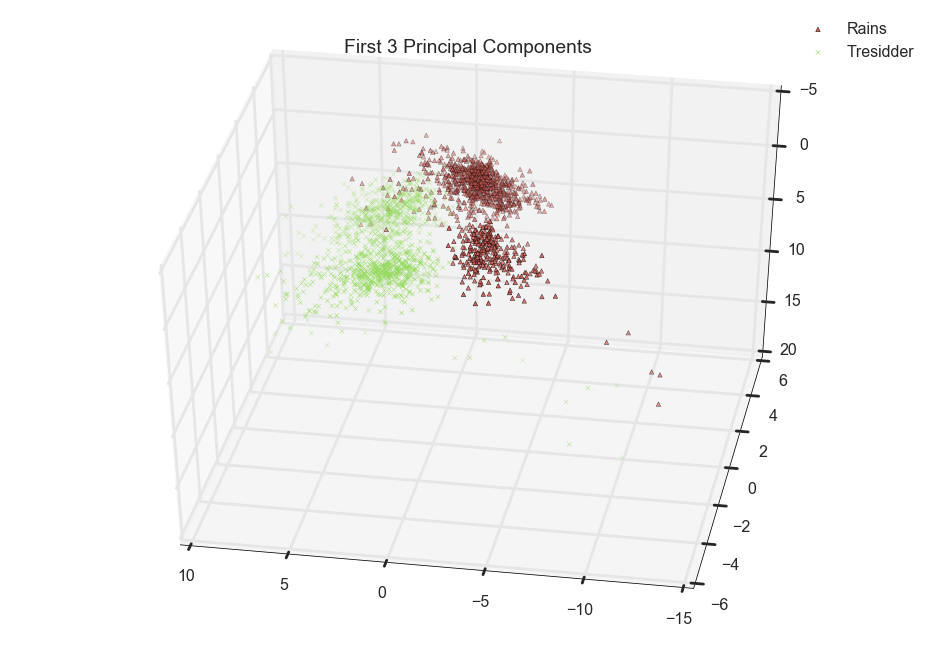

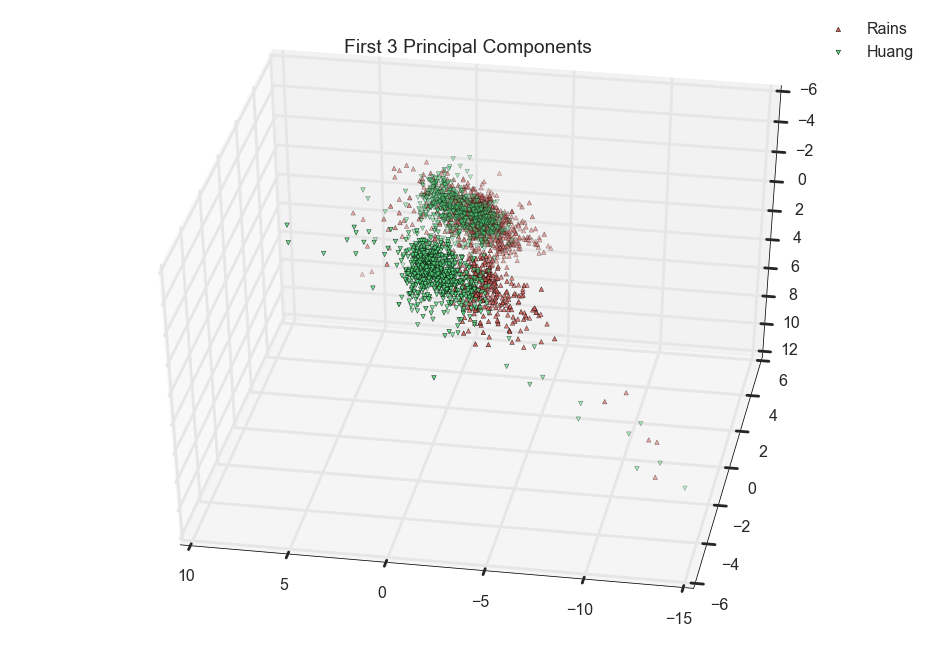

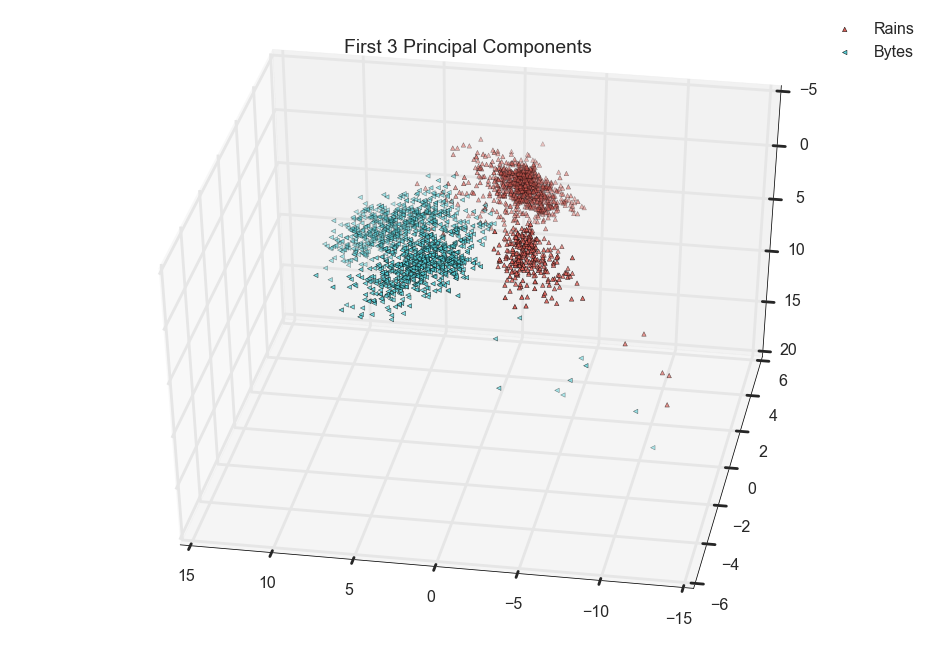

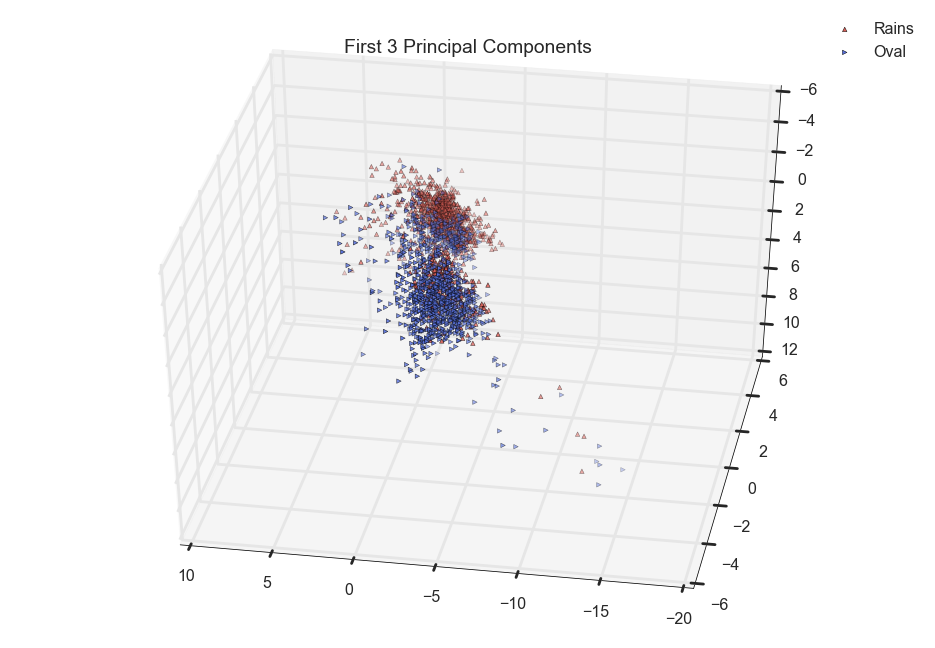

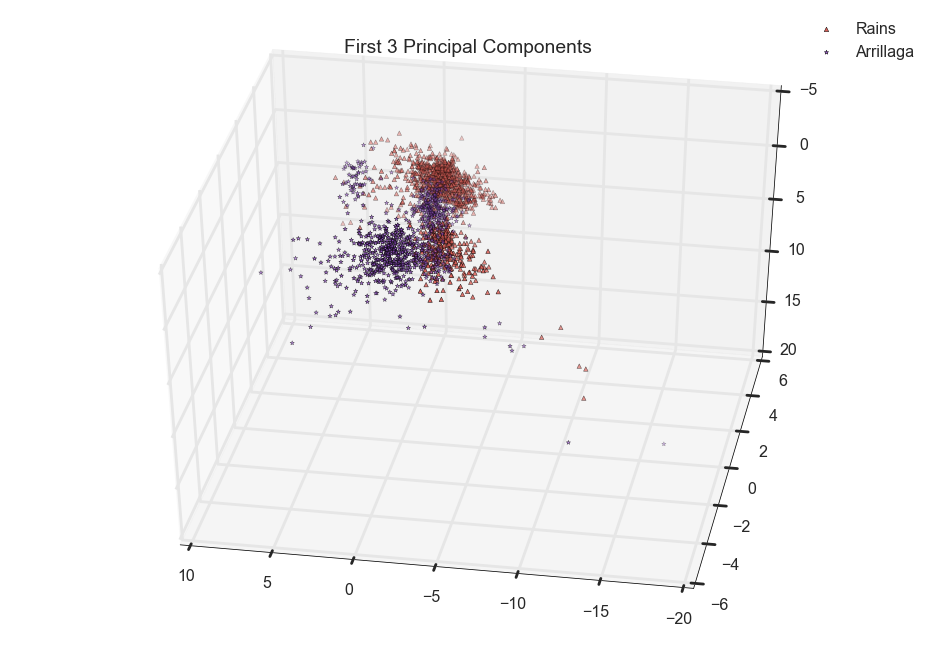

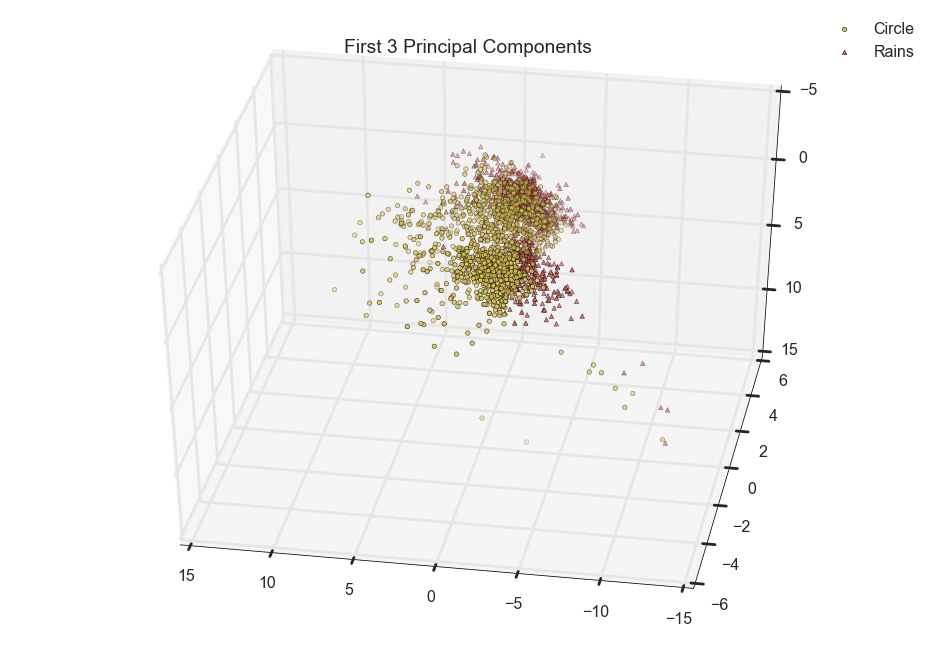

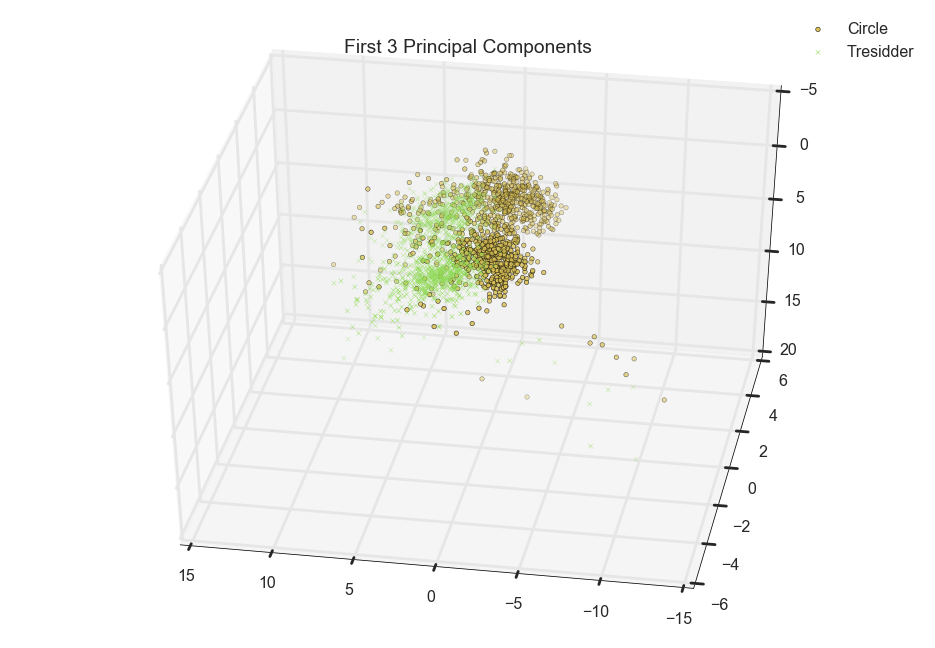

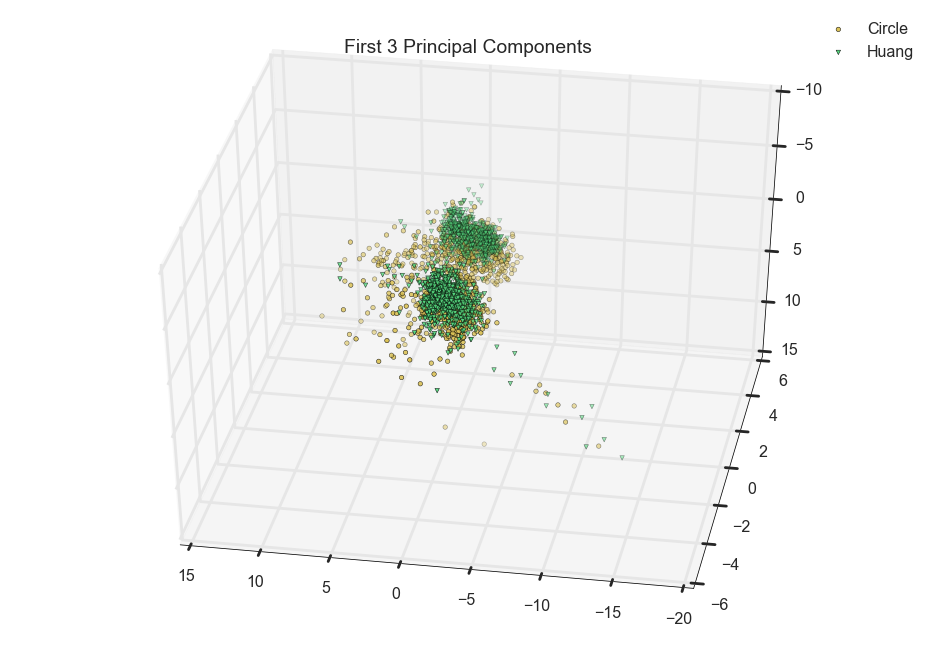

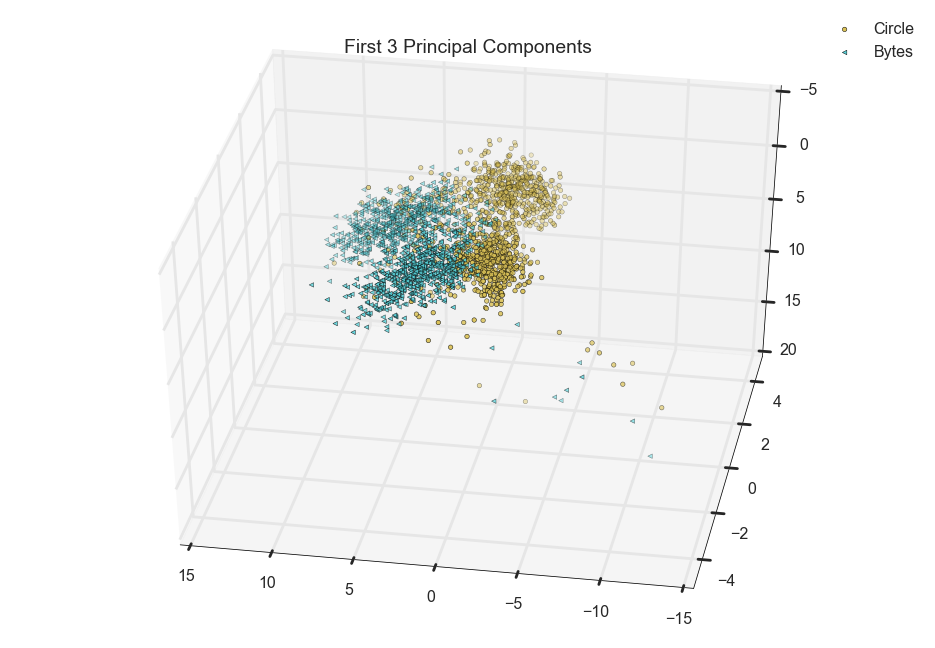

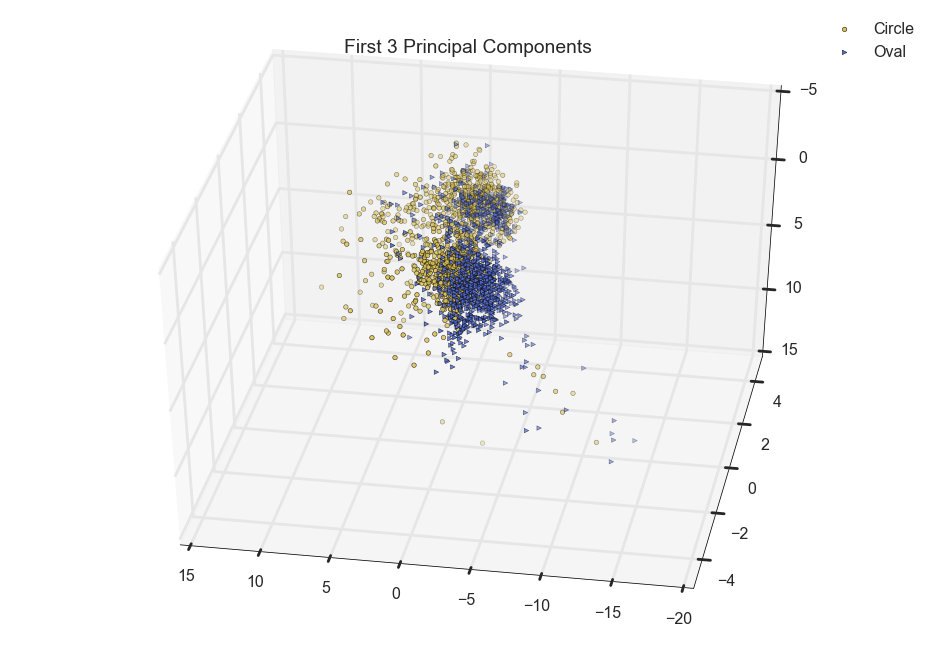

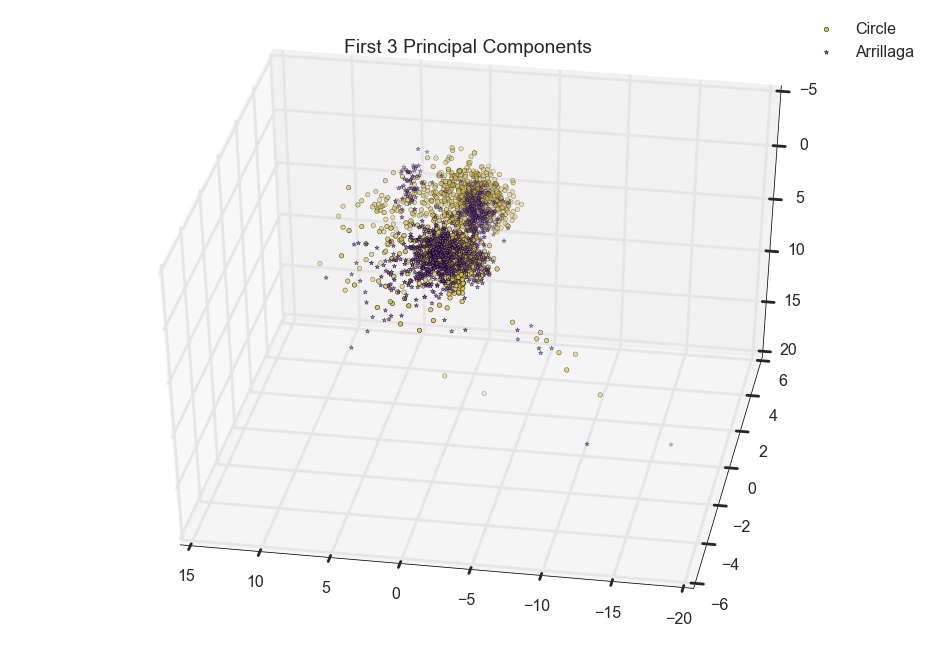

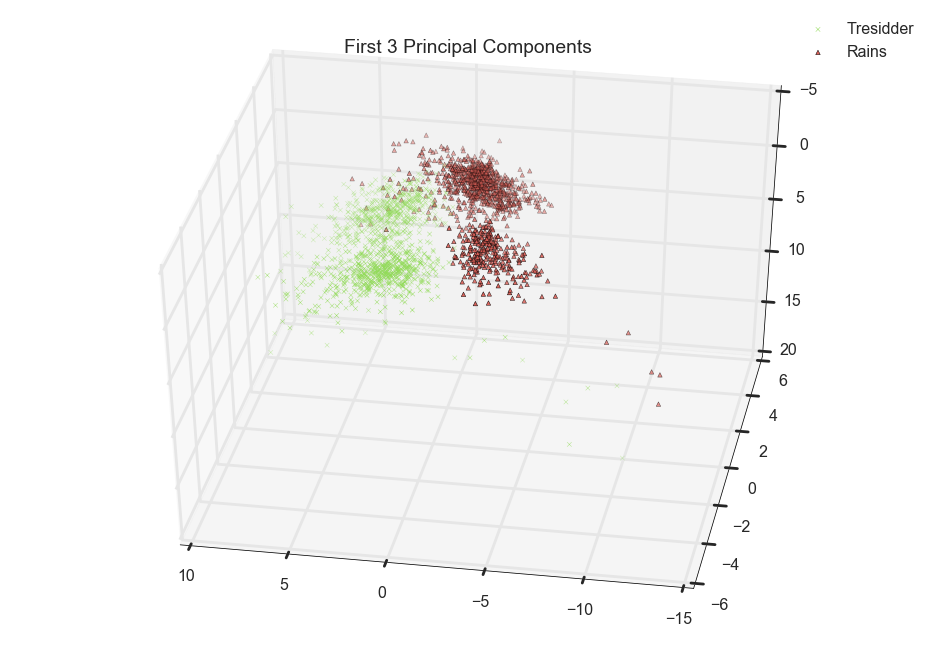

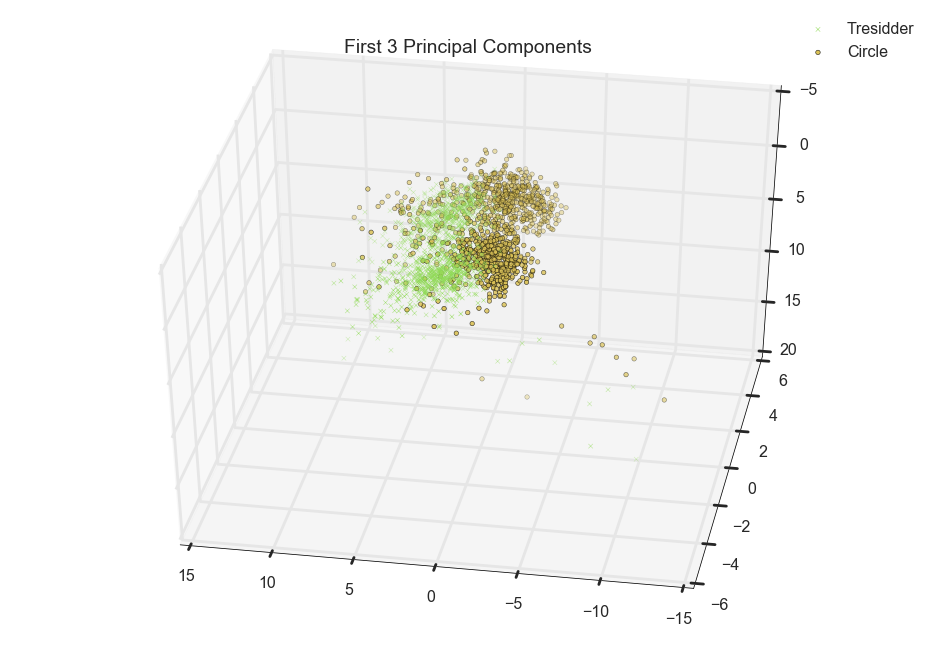

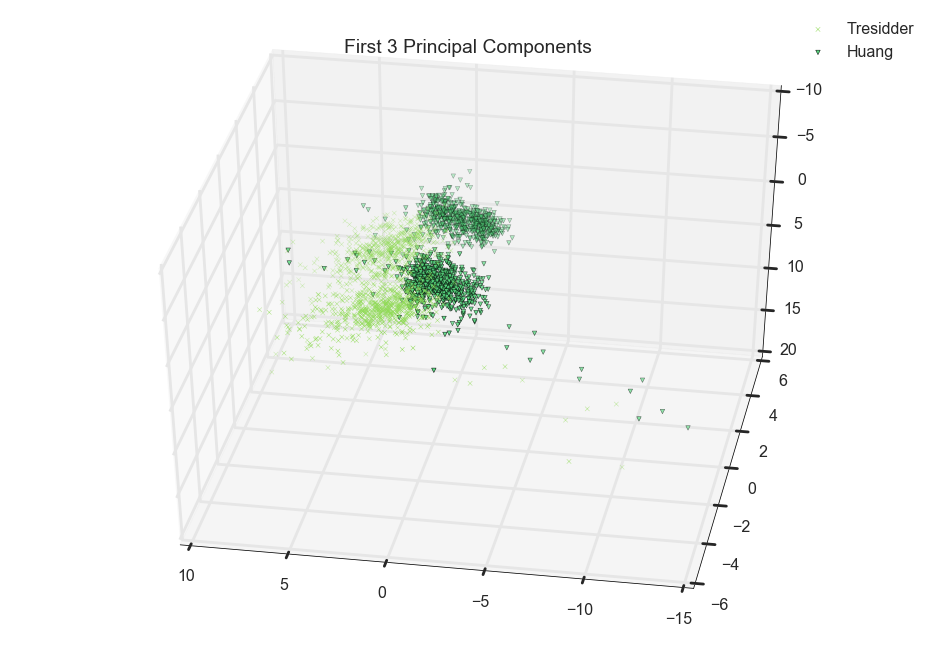

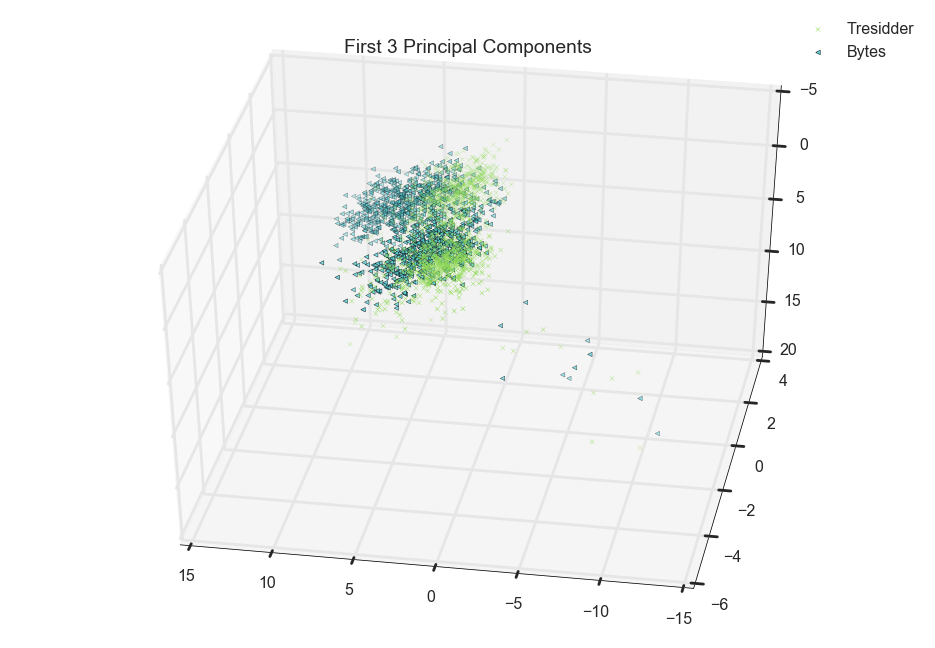

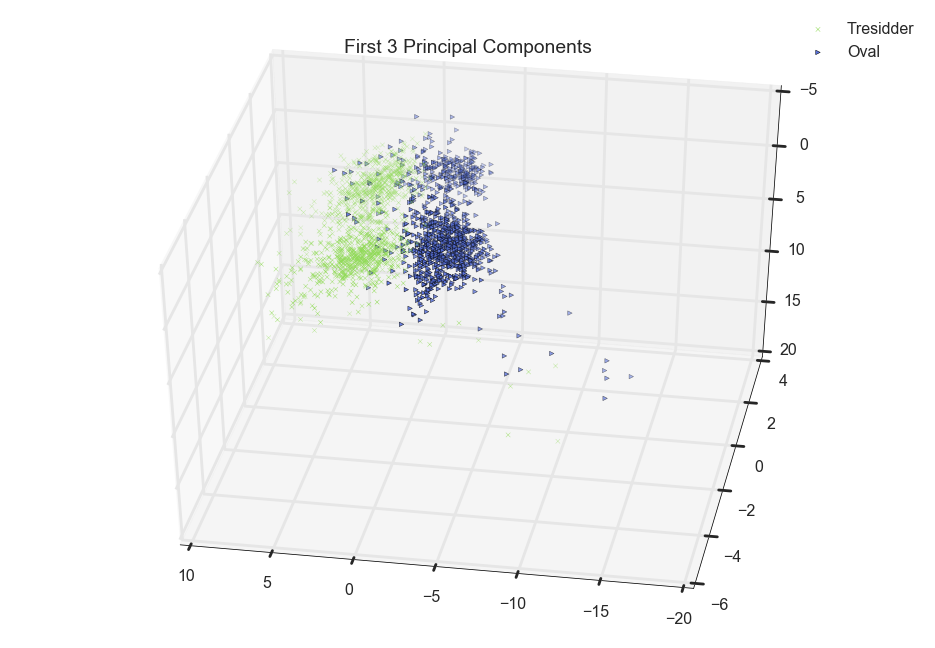

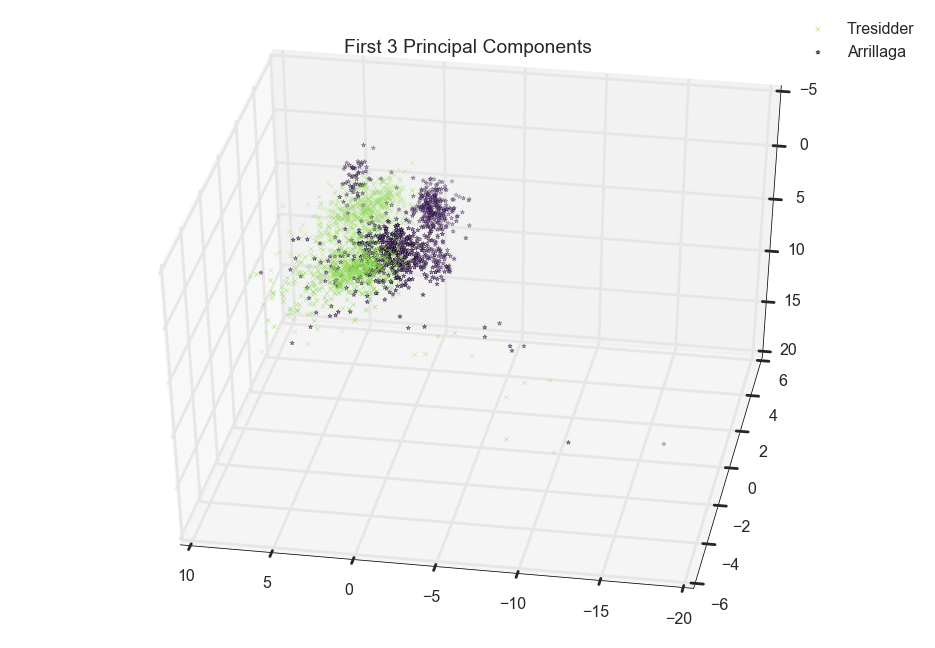

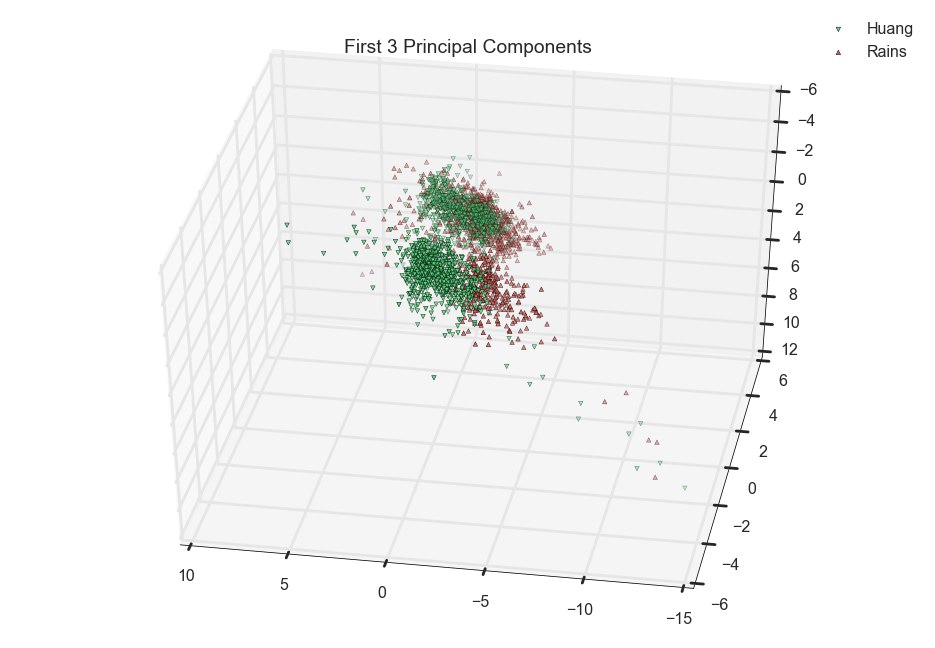

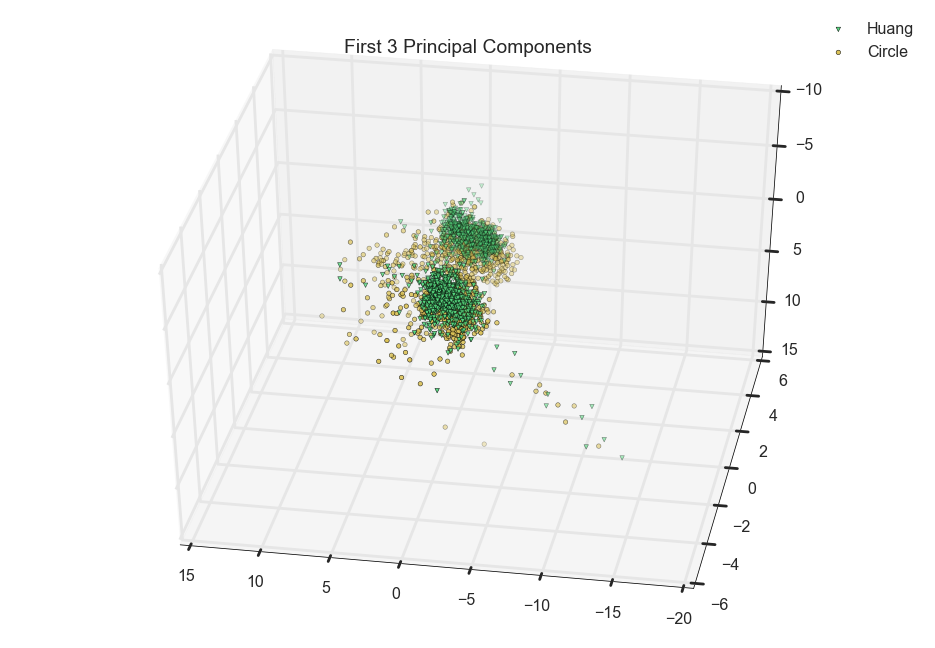

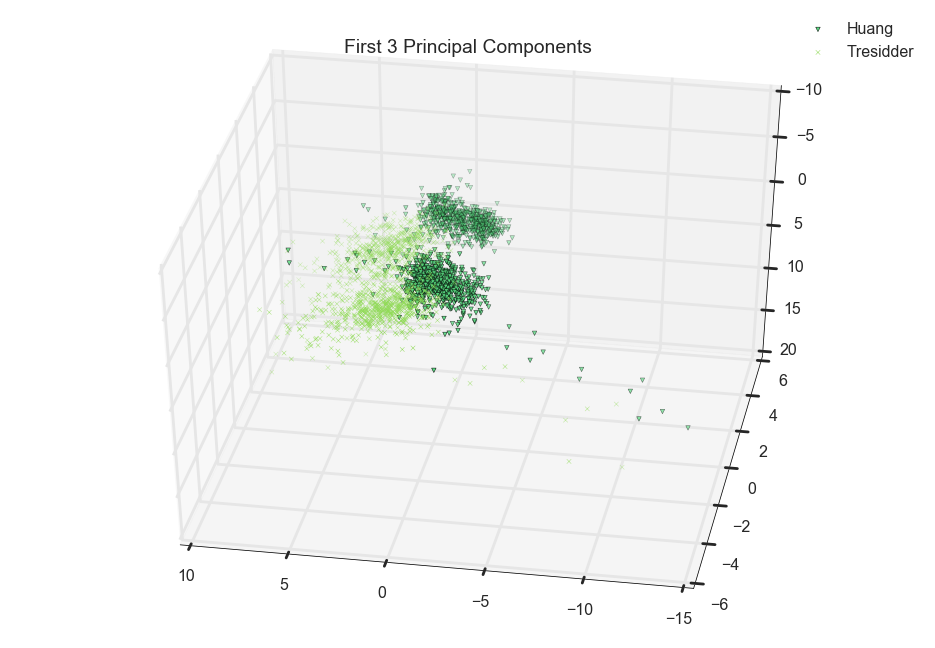

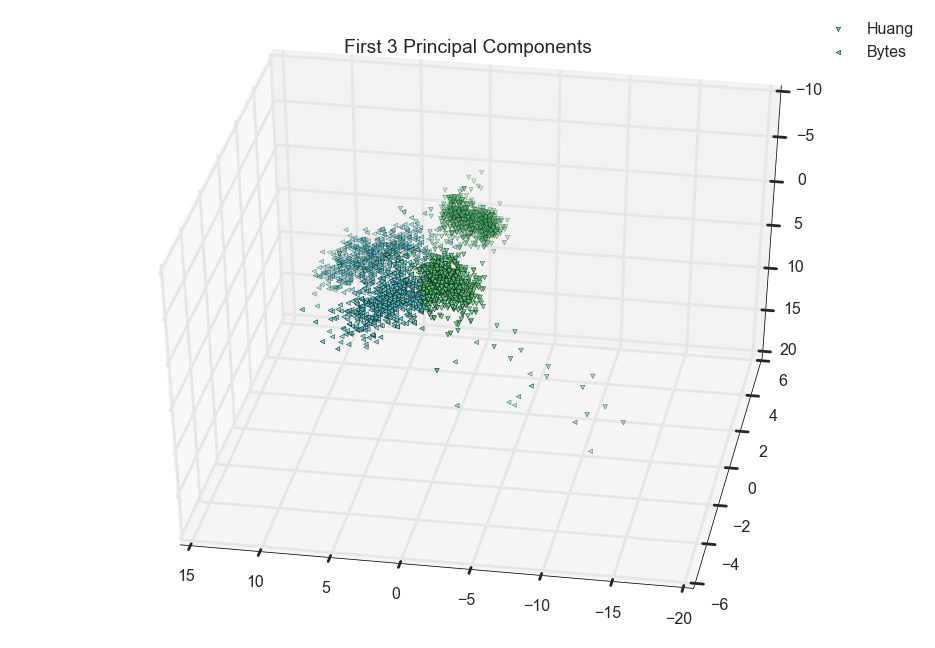

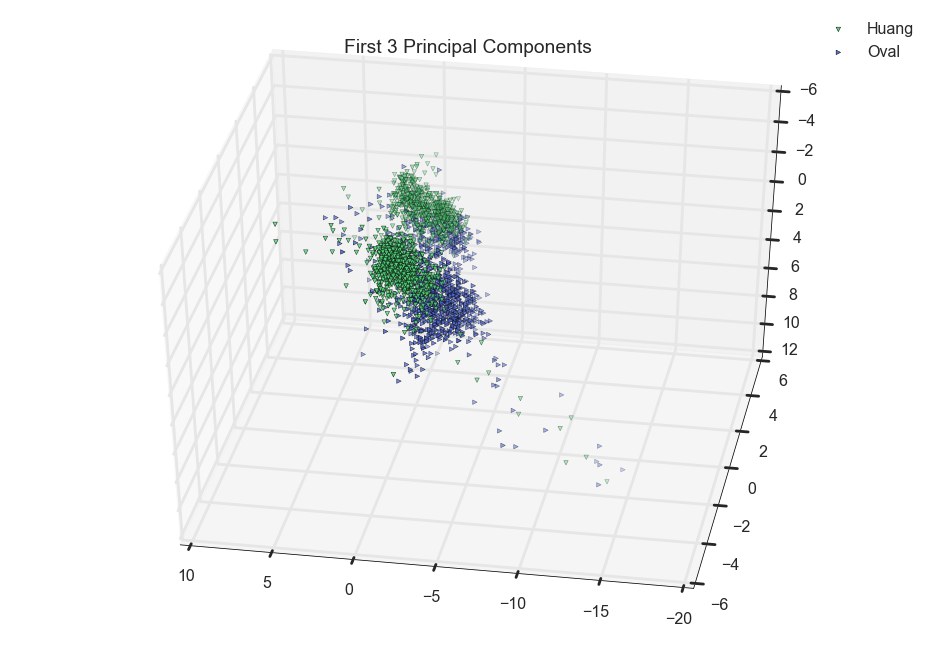

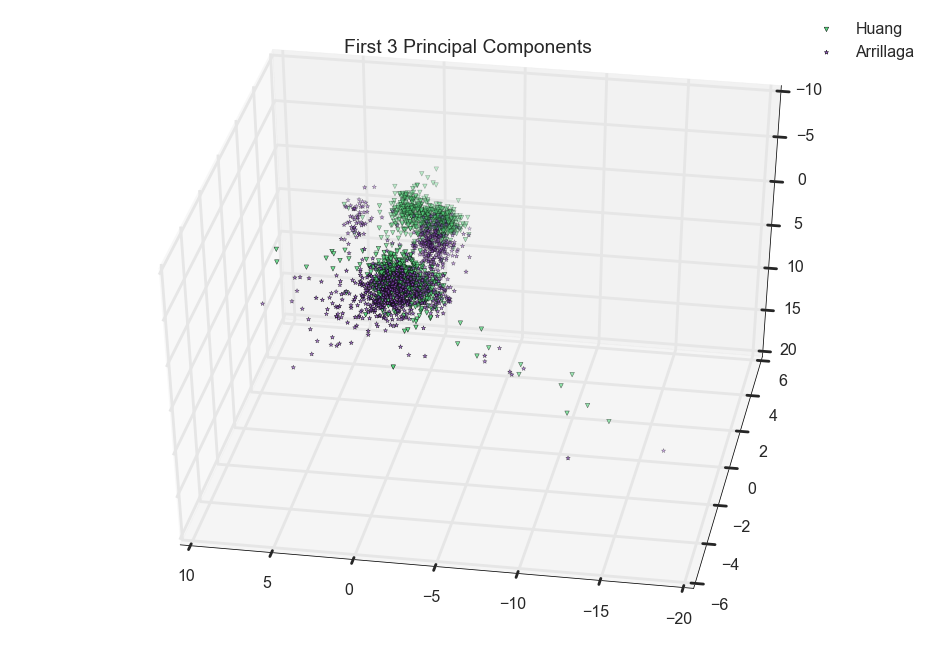

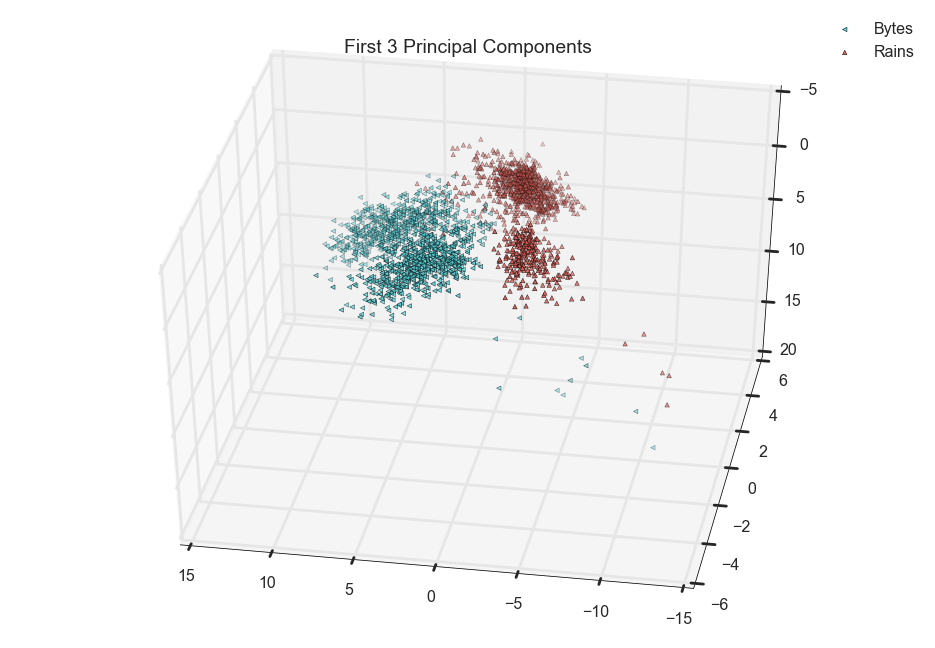

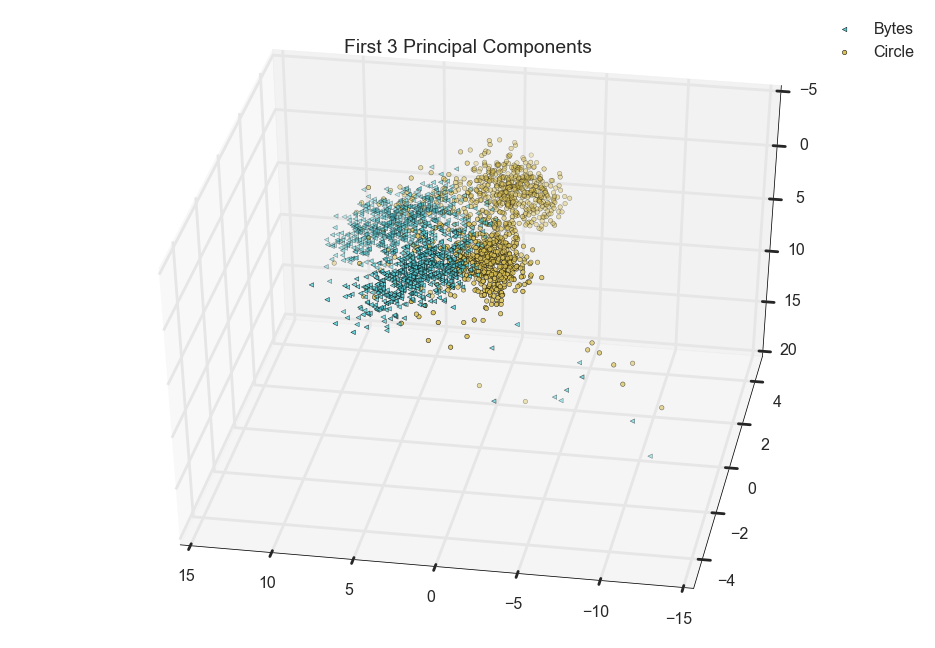

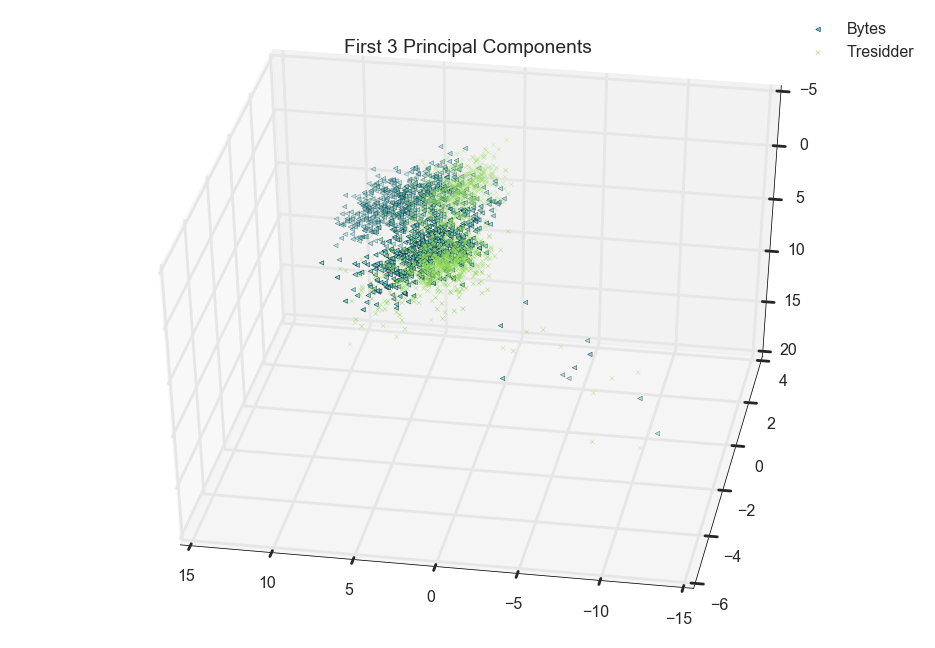

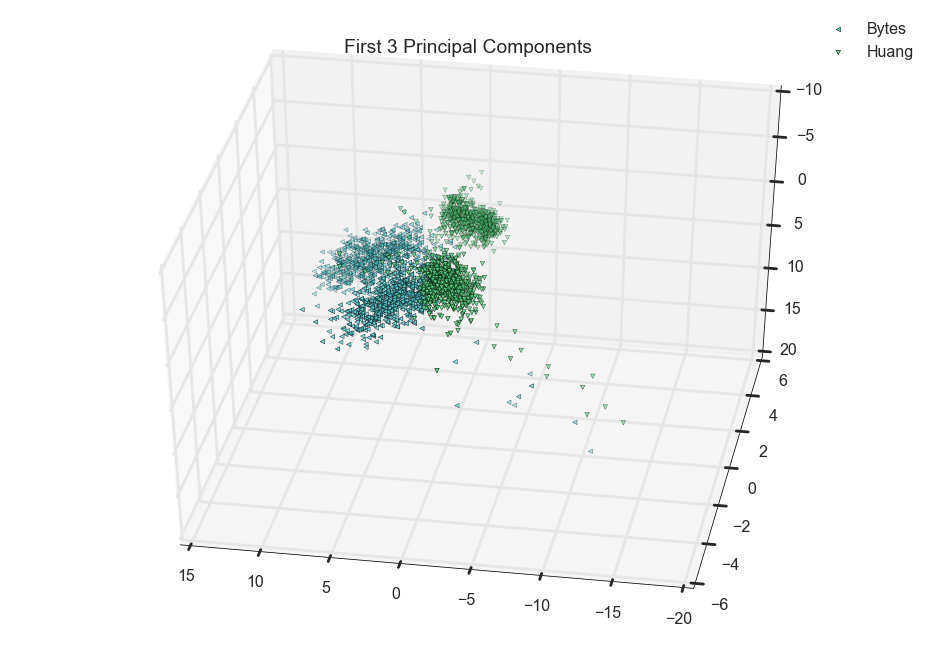

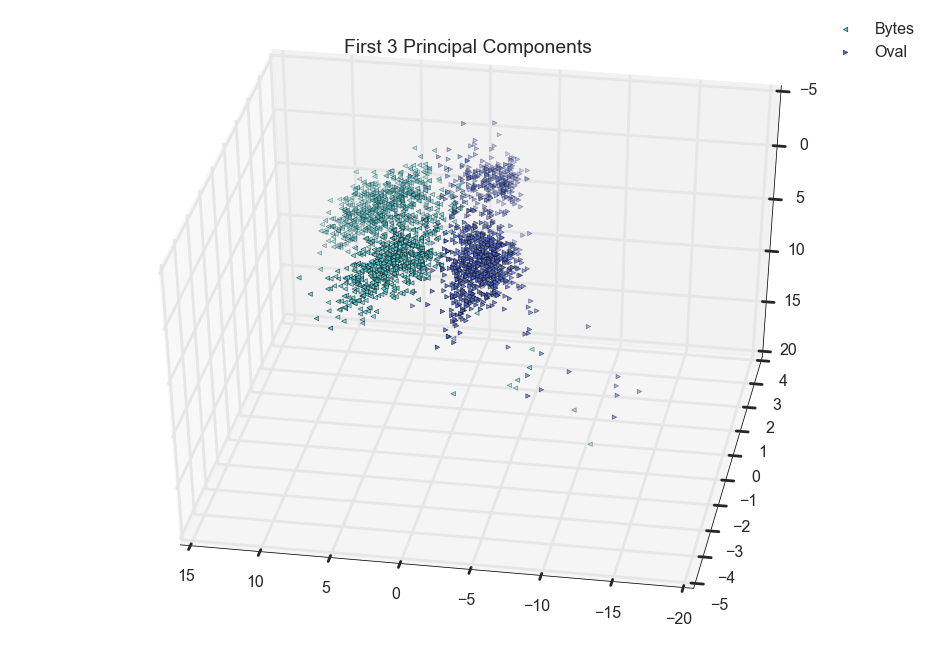

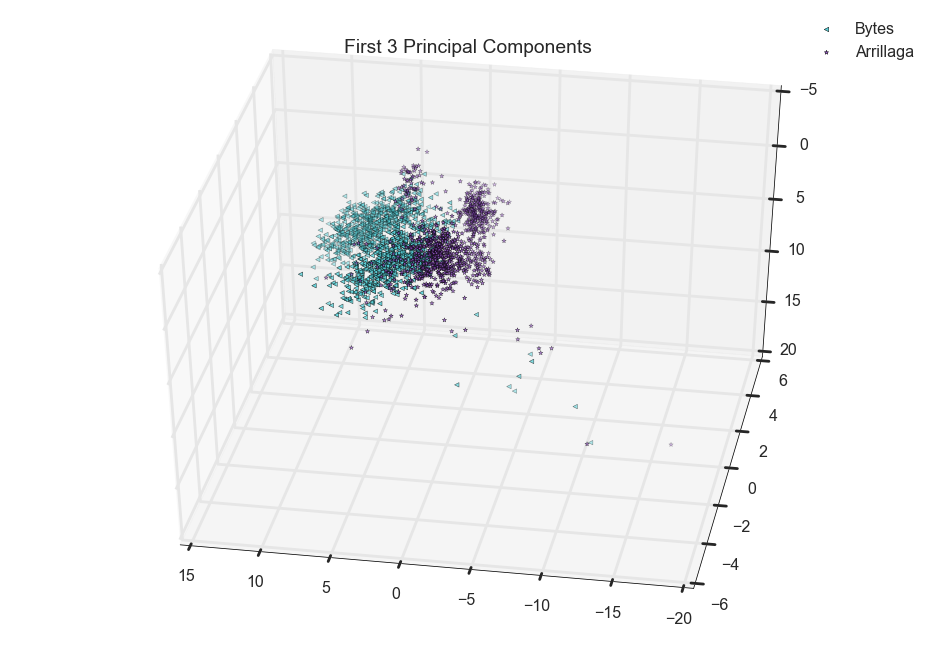

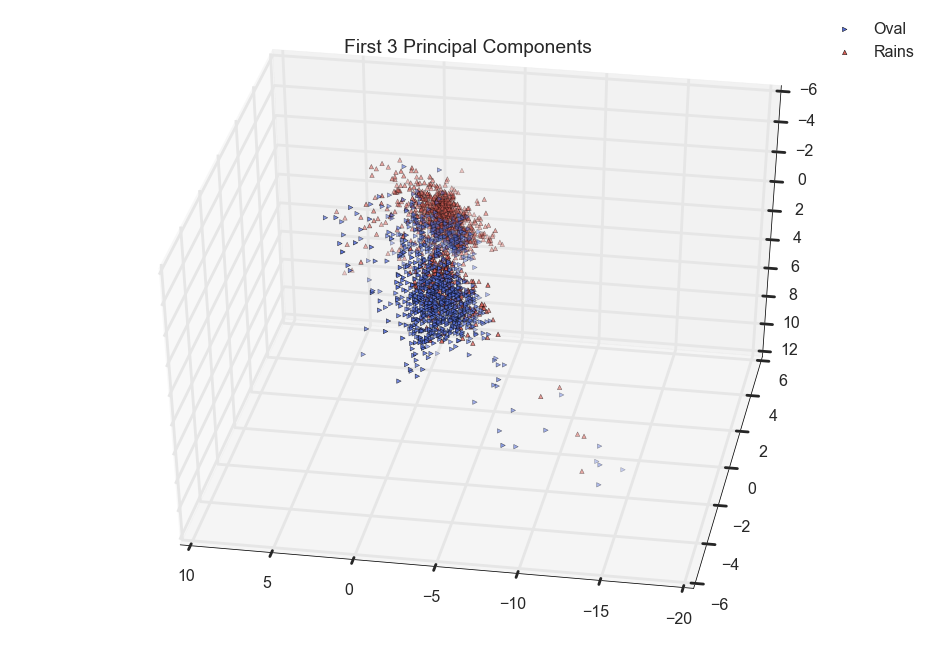

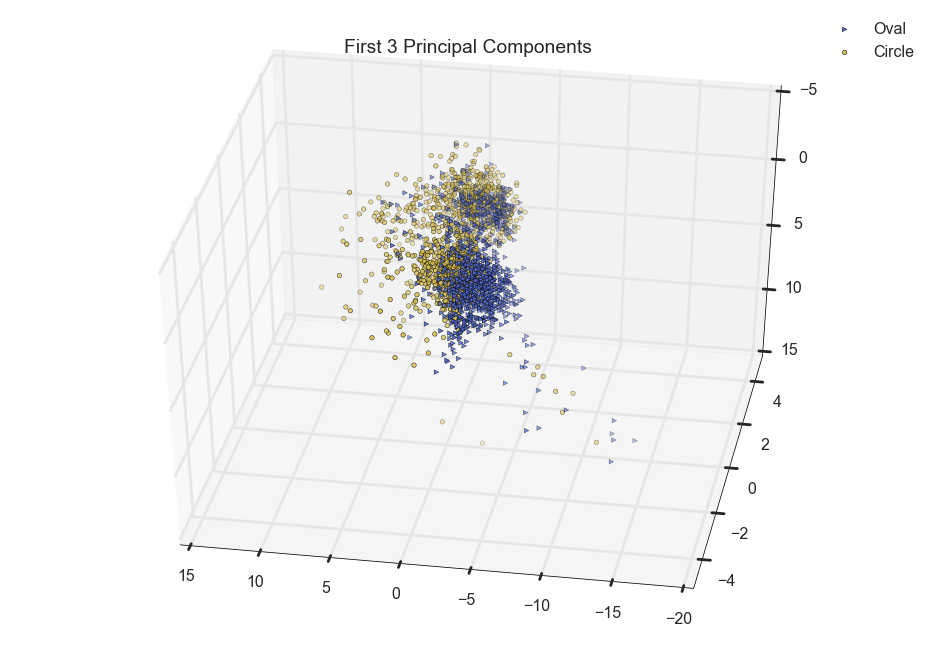

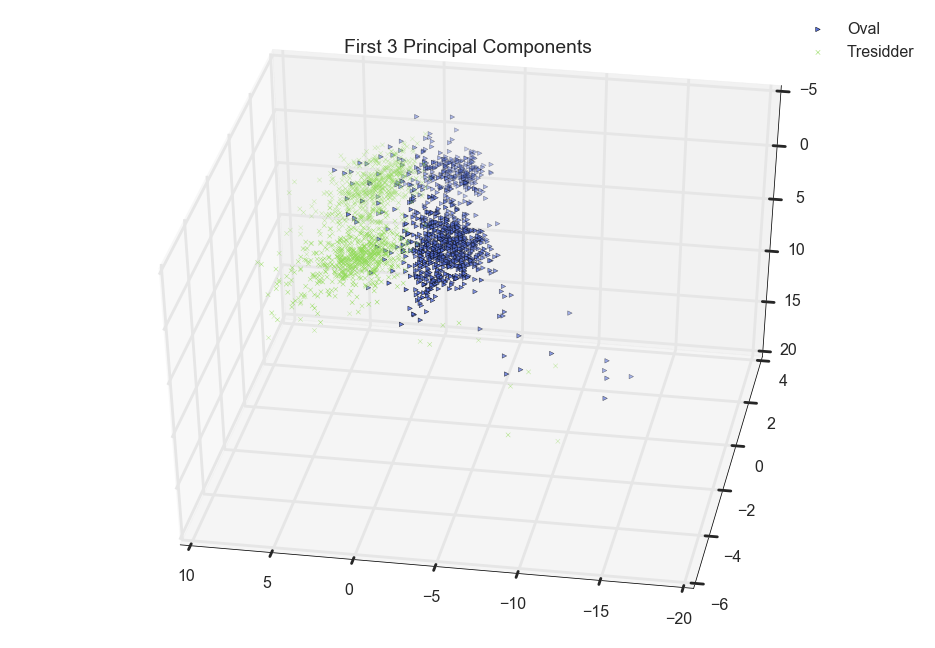

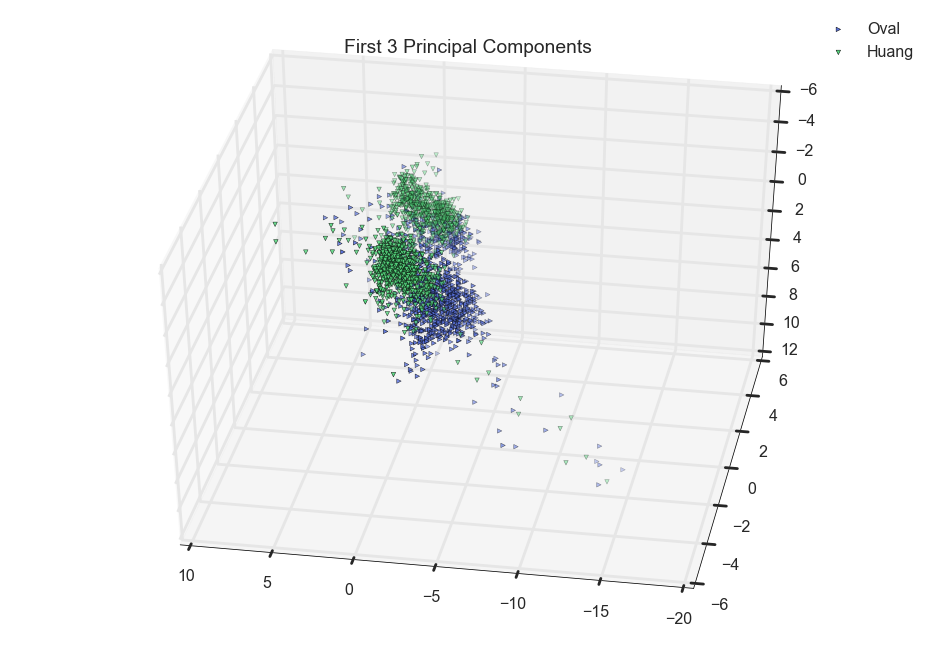

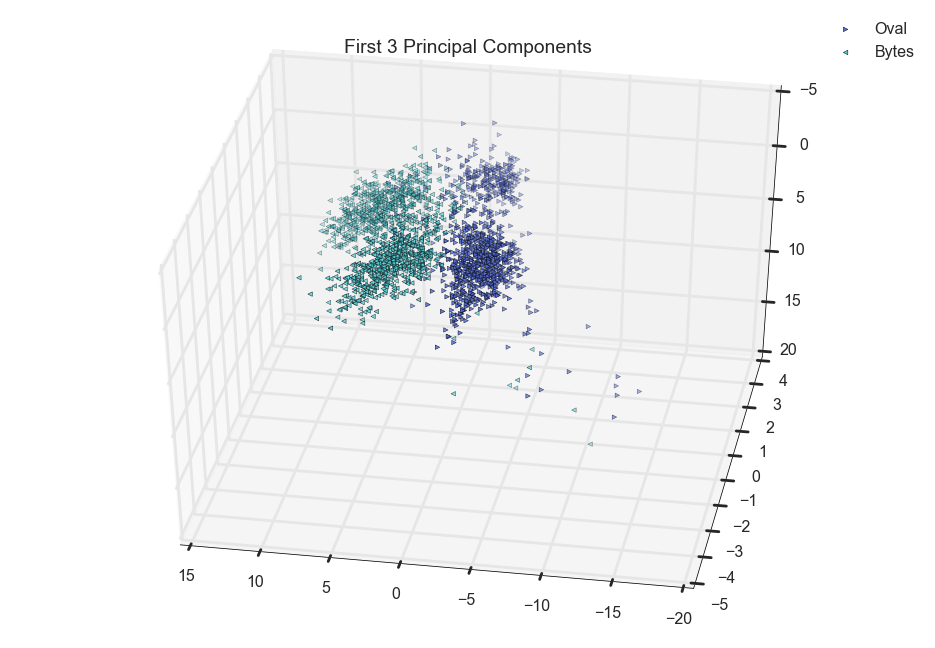

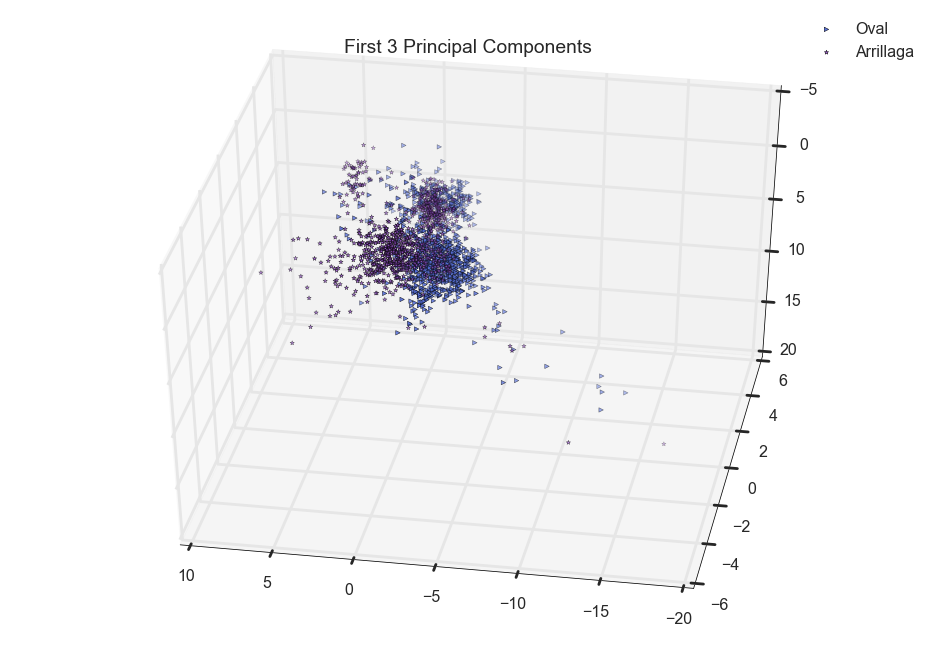

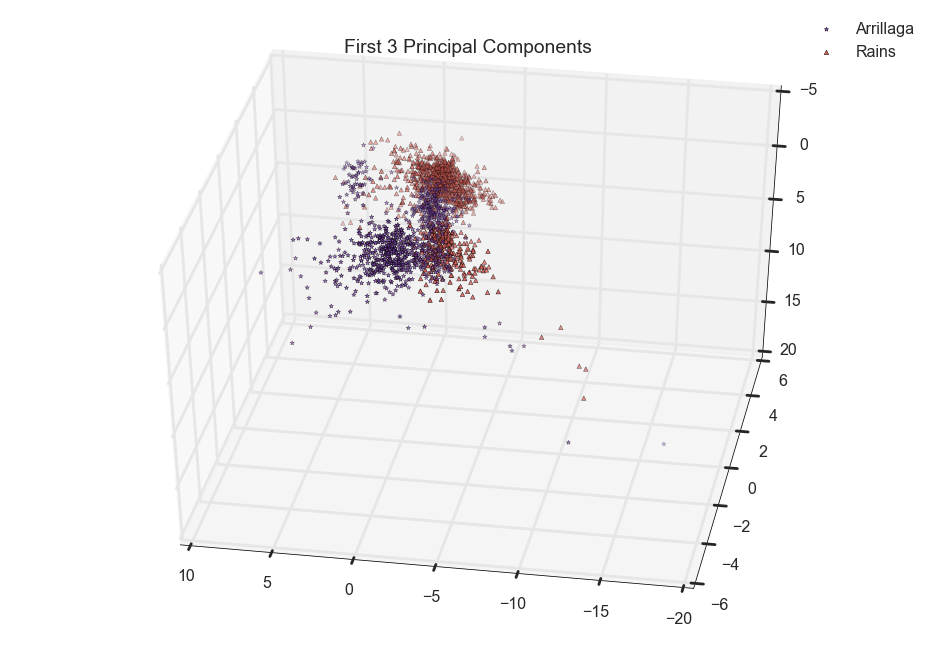

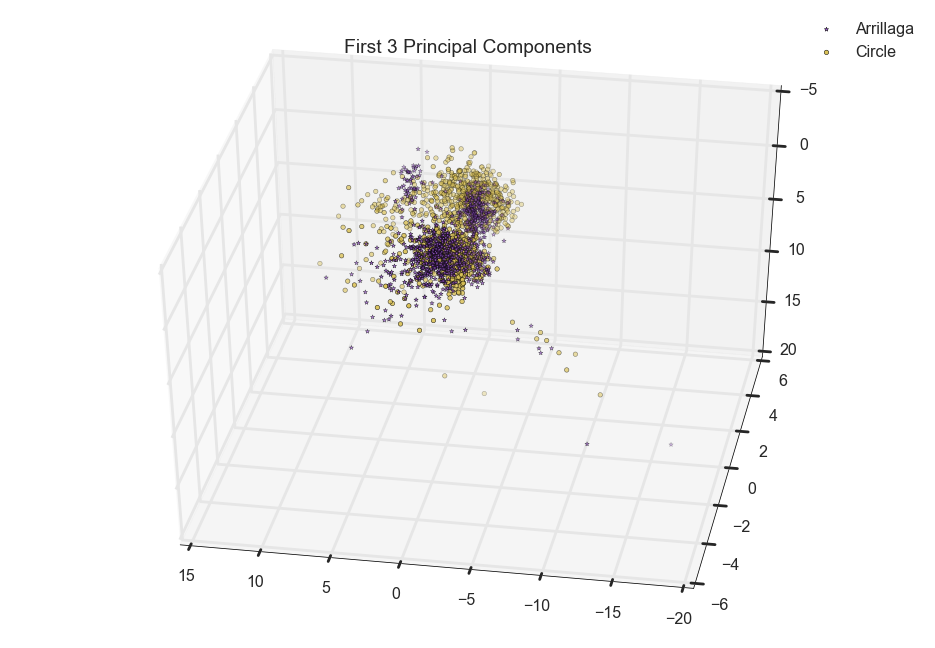

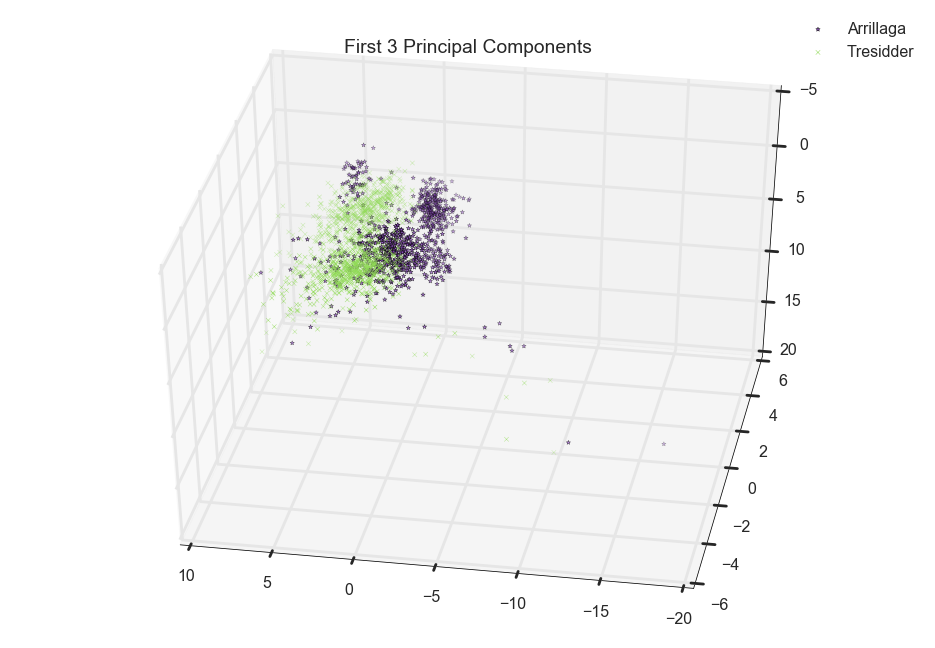

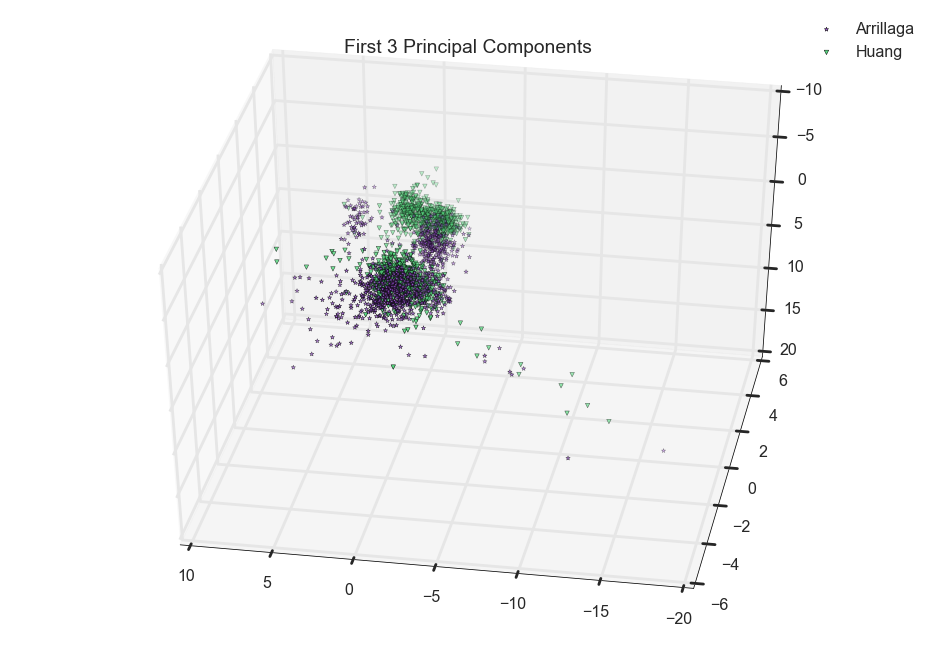

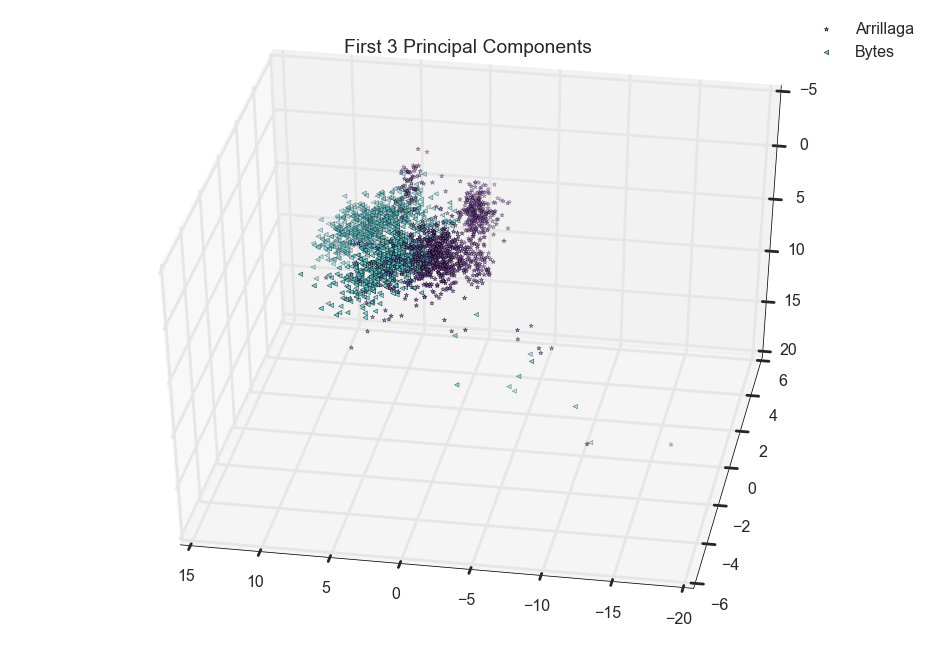

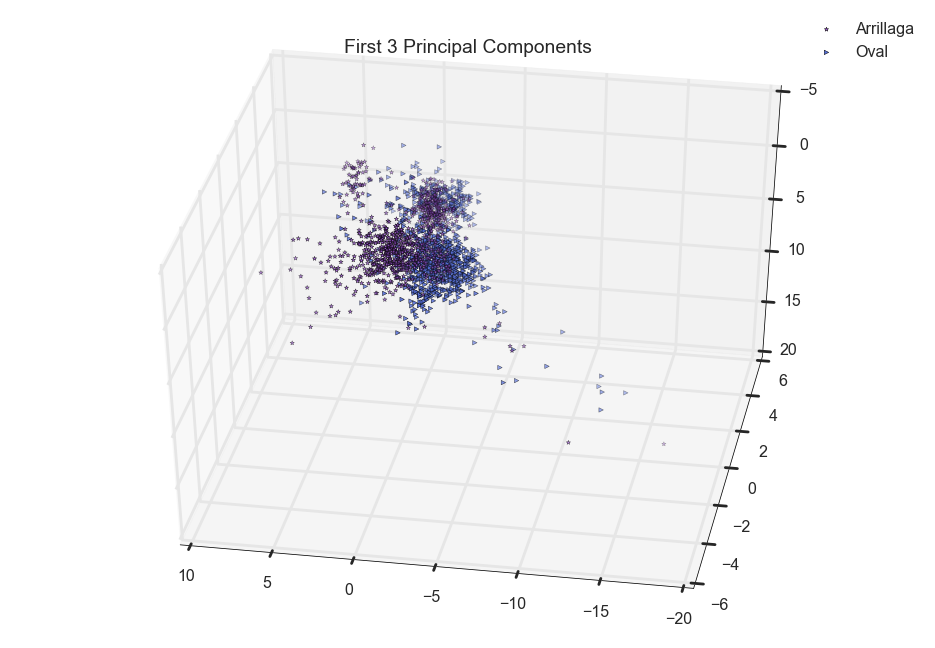

In [39]:
for i in range(7):
    for j in range(7):
        if i != j:
            plotRegions(samples.REGIONS,pca_df,i,j)

# Classifying using PCA Features

In [22]:
pca_X_sample = np.zeros((m,nsub,num_pcs))
pca_Y_sample = Y_compact
for i in range(m):
    for j in range(nsub):
        pca_X_sample[i,j,:] = X_pca[i*nsub+j,:num_pcs]
(pca_X_train,pca_Y_train,pca_X_test,pca_Y_test) = audiolearning.train_test_split_audio(pca_X_sample,pca_Y_sample)

In [23]:
class pcaPhi:
    LEN = num_pcs;
    raw_phi = None
    pca_obj = None
    def __init__(self,raw_phi,pca_obj):
        self.raw_phi = raw_phi
        self.pca_obj = pca_obj
    def get_phi(self,sample):
        '''
        Takes in a super_sample and returns a feature array. Breaks the super_sample
        down into samples. Each row of the returned value corresponds to a sample
        in the super sample.
        '''
        raw = self.raw_phi.get_phi(sample)

        return self.pca_obj.transform(raw)
my_pca_phi = pcaPhi(myPhi,pca)

In [24]:
svm_classifier = audiolearning.Classifier(my_pca_phi)
svm_classifier.trainSVMBatch(train_samples=None, X_train=pca_X_train,Y_train=pca_Y_train,C=0.6)

Finished Training Classifier with Training Error:---------------
Error for region 0: 0.0116
Error for region 1: 0.0920
Error for region 2: 0.0000
Error for region 3: 0.0115
Error for region 4: 0.0000
Error for region 5: 0.0513
Error for region 6: 0.0526
---- Total Training Error: 0.0304


0.030411449016100156

In [25]:
svm_classifier.testClassifier(test_samples=None,X_test=pca_X_test,Y_test=pca_Y_test)

-----------------------------------------------------
-------------------Testing Error:-------------------
Error for region 0: 0.0000
Error for region 1: 0.3636
Error for region 2: 0.0263
Error for region 3: 0.0889
Error for region 4: 0.0789
Error for region 5: 0.1250
Error for region 6: 0.2424
---- Total Testing Error: 0.1297


0.12970711297071125

In [26]:
from sklearn.cross_validation import train_test_split
Xlr, Xtestlr, ylr, ytestlr = train_test_split(X_pca, Y)

In [29]:
from sklearn.grid_search import GridSearchCV
svm_tester = svm.SVC()
parameters = {"C":np.logspace(-3,3,7), "gamma":np.logspace(-3,3,7)}
fitmodel = GridSearchCV(svm_tester,param_grid=parameters,cv=5,scoring="accuracy")
fitmodel.fit(Xlr,ylr)
fitmodel.best_estimator_, fitmodel.best_params_, fitmodel.best_score_, fitmodel.grid_scores_

(SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
   max_iter=-1, probability=False, random_state=None, shrinking=True,
   tol=0.001, verbose=False),
 {'C': 10.0, 'gamma': 0.01},
 0.89874686716791985,
 [mean: 0.16374, std: 0.00023, params: {'C': 0.001, 'gamma': 0.001},
  mean: 0.16374, std: 0.00023, params: {'C': 0.001, 'gamma': 0.01},
  mean: 0.16374, std: 0.00023, params: {'C': 0.001, 'gamma': 0.10000000000000001},
  mean: 0.16374, std: 0.00023, params: {'C': 0.001, 'gamma': 1.0},
  mean: 0.16374, std: 0.00023, params: {'C': 0.001, 'gamma': 10.0},
  mean: 0.16374, std: 0.00023, params: {'C': 0.001, 'gamma': 100.0},
  mean: 0.16374, std: 0.00023, params: {'C': 0.001, 'gamma': 1000.0},
  mean: 0.16374, std: 0.00023, params: {'C': 0.01, 'gamma': 0.001},
  mean: 0.41771, std: 0.00575, params: {'C': 0.01, 'gamma': 0.01},
  mean: 0.16374, std: 0.00023, params: {'C': 0.01, 'gamma': 0.10000000000000001},
  mean: 0.

In [31]:
C = fitmodel.best_params_['C']
gamma = fitmodel.best_params_['gamma']

In [32]:
svm_classifier_grid = audiolearning.Classifier(my_pca_phi)
svm_classifier_grid.trainSVMBatch(train_samples=None, X_train=pca_X_train,Y_train=pca_Y_train,C=C,gamma=gamma)

Finished Training Classifier with Training Error:---------------
Error for region 0: 0.0000
Error for region 1: 0.0000
Error for region 2: 0.0000
Error for region 3: 0.0000
Error for region 4: 0.0000
Error for region 5: 0.0256
Error for region 6: 0.0000
---- Total Training Error: 0.0036


0.003577817531305927

In [35]:
(err, conf_mat) = svm_classifier.testClassifier(test_samples=None,X_test=pca_X_test,Y_test=pca_Y_test,get_conf_mat=True)

-----------------------------------------------------
-------------------Testing Error:-------------------
Error for region 0: 0.0000
Error for region 1: 0.3333
Error for region 2: 0.0263
Error for region 3: 0.0667
Error for region 4: 0.1053
Error for region 5: 0.1667
Error for region 6: 0.2121
---- Total Testing Error: 0.1255


In [36]:
conf_mat

array([[28,  0,  0,  0,  0,  0,  0],
       [ 2, 22,  2,  4,  0,  3,  0],
       [ 0,  1, 37,  0,  0,  0,  0],
       [ 1,  1,  0, 42,  0,  1,  0],
       [ 0,  1,  3,  0, 34,  0,  0],
       [ 1,  1,  0,  2,  0, 20,  0],
       [ 0,  6,  0,  0,  1,  0, 26]])

In [75]:
tree_classifier_grid = audiolearning.Classifier(my_pca_phi)
tree_classifier_grid.trainDecisionTreeBatch(train_samples=None, X_train=pca_X_train,Y_train=pca_Y_train,max_depth=67,max_leaf_nodes=100)

Finished Training Classifier with Training Error:---------------
Error for region 0: 0.0930
Error for region 1: 0.3793
Error for region 2: 0.0122
Error for region 3: 0.0115
Error for region 4: 0.0000
Error for region 5: 0.2179
Error for region 6: 0.1404
---- Total Training Error: 0.1216


0.12164579606440074

In [76]:
tree_classifier_grid.testClassifier(test_samples=None,X_test=pca_X_test,Y_test=pca_Y_test,get_conf_mat=True)

-----------------------------------------------------
-------------------Testing Error:-------------------
Error for region 0: 0.1786
Error for region 1: 0.4848
Error for region 2: 0.0526
Error for region 3: 0.1556
Error for region 4: 0.0789
Error for region 5: 0.2917
Error for region 6: 0.4242
---- Total Testing Error: 0.2259


(0.2259414225941423, array([[23,  2,  1,  1,  0,  0,  1],
        [ 6, 17,  2,  3,  1,  4,  0],
        [ 0,  1, 36,  0,  1,  0,  0],
        [ 1,  3,  1, 38,  0,  2,  0],
        [ 0,  0,  3,  0, 35,  0,  0],
        [ 1,  4,  0,  2,  0, 17,  0],
        [ 2,  2,  5,  4,  0,  1, 19]]))

In [72]:
dt_tester = tree.DecisionTreeClassifier()
parameters = {"max_depth":np.arange(1,110,11), "max_leaf_nodes":np.arange(2,110,11), "criterion":["gini","entropy"]}
fitmodel = GridSearchCV(dt_tester,param_grid=parameters,cv=5,scoring="accuracy")
fitmodel.fit(Xlr,ylr)
fitmodel.best_estimator_, fitmodel.best_params_, fitmodel.best_score_, fitmodel.grid_scores_

(DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=67,
             max_features=None, max_leaf_nodes=101, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             presort=False, random_state=None, splitter='best'),
 {'criterion': 'gini', 'max_depth': 67, 'max_leaf_nodes': 101},
 0.61136173767752711,
 [mean: 0.29373, std: 0.00276, params: {'max_leaf_nodes': 2, 'criterion': 'gini', 'max_depth': 1},
  mean: 0.42590, std: 0.01113, params: {'max_leaf_nodes': 13, 'criterion': 'gini', 'max_depth': 1},
  mean: 0.42590, std: 0.01113, params: {'max_leaf_nodes': 24, 'criterion': 'gini', 'max_depth': 1},
  mean: 0.42590, std: 0.01113, params: {'max_leaf_nodes': 35, 'criterion': 'gini', 'max_depth': 1},
  mean: 0.42590, std: 0.01113, params: {'max_leaf_nodes': 46, 'criterion': 'gini', 'max_depth': 1},
  mean: 0.42590, std: 0.01113, params: {'max_leaf_nodes': 57, 'criterion': 'gini', 'max_depth': 1},
  mean: 0.42590, std: 0.01113, params: 

In [ ]:
dt_tester = ensemble.RandomForestClassifier()
parameters = {"n_estimators":np.arange(1,1000,10), "max_features":np.arange(1,num_pcs)}
fitmodel = GridSearchCV(dt_tester,param_grid=parameters,cv=5,scoring="accuracy")
fitmodel.fit(Xlr,ylr)
fitmodel.best_estimator_, fitmodel.best_params_, fitmodel.best_score_, fitmodel.grid_scores_

In [100]:
rf_clf = audiolearning.Classifier(my_pca_phi)
rf_clf.trainRandomForestBatch(train_samples=None, X_train=pca_X_train,Y_train=pca_Y_train,n_estimators=100,max_features=20,n_jobs=-1)

Finished Training Classifier with Training Error:---------------
Error for region 0: 0.0000
Error for region 1: 0.0000
Error for region 2: 0.0000
Error for region 3: 0.0000
Error for region 4: 0.0000
Error for region 5: 0.0000
Error for region 6: 0.0000
---- Total Training Error: 0.0000


0.0

In [101]:
rf_clf.testClassifier(test_samples=None,X_test=pca_X_test,Y_test=pca_Y_test,get_conf_mat=True)[1]

-----------------------------------------------------
-------------------Testing Error:-------------------
Error for region 0: 0.1071
Error for region 1: 0.5152
Error for region 2: 0.2632
Error for region 3: 0.1556
Error for region 4: 0.1316
Error for region 5: 0.1250
Error for region 6: 0.2727
---- Total Testing Error: 0.2259


array([[25,  1,  0,  0,  0,  2,  0],
       [ 2, 16,  3,  5,  2,  3,  2],
       [ 0,  0, 28,  0, 10,  0,  0],
       [ 2,  5,  0, 38,  0,  0,  0],
       [ 0,  1,  4,  0, 33,  0,  0],
       [ 2,  0,  1,  0,  0, 21,  0],
       [ 0,  5,  2,  0,  2,  0, 24]])